In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import sklearn.preprocessing
import sklearn.model_selection

In [8]:
import uproot
uproot.default_library = "np"

In [9]:
import os.path

In [10]:
import logging
logging.basicConfig(level=logging.INFO)

In [11]:
np.set_printoptions(precision=4, suppress=True)

In [12]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

### Data

In [13]:
class DataFile(object):
    def __init__(self, path, name):
        pass

In [14]:
raw_names = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [15]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

In [16]:
def true_features(f):
    return [name for name in f.keys() if "TRUE" in name]
def common_features(*fs):
    return sorted(set.intersection(*[set(true_features(f)) for f in fs]))
common_features(*raw_files)

['angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Truthing

In [17]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [18]:
aliases = {
    #"BM":     "sqrt(B_plus_TRUEP_E**2-B_plus_TRUEPT**2-B_plus_TRUEP_Z**2)",
    "ll_E":   "e_plus_TRUEP_E + e_minus_TRUEP_E",
    "ll_X":   "e_plus_TRUEP_X + e_minus_TRUEP_X",
    "ll_Y":   "e_plus_TRUEP_Y + e_minus_TRUEP_Y",
    "ll_Z":   "e_plus_TRUEP_Z + e_minus_TRUEP_Z",
    "ll_M2":  "ll_E**2 - ll_X**2 - ll_Y**2 - ll_Z**2",
    #"JM":     "J_psi_1S_M_TRUE",
    #"BM":     "B_plus_M_TRUE",
    #"q2_" :   "J_psi_1S_TRUEP_E**2-J_psi_1S_TRUEPT**2-J_psi_1S_TRUEP_Z**2",
    #"q":      "J_psi_1S_M",
    #"q2":     "q**2",
    "q2":     "ll_M2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
    "log_max_pl": "log(max_pl)",
}
aliases = {
    "alpha": "angle_ee_TRUE",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_ep_PT": "log(ep_PT_TRUE)",
    "log_em_PT": "log(em_PT_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",
}

In [19]:
features = [
    "min_pl",
    "max_pl",
    "ppcos_ll",
    "cos_ll",
    "log_max_pl",
    "alpha",
    "q2",
]
features = list(aliases.keys())

In [20]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
D_selector = "abs(D_plus_TRUEID)==411"
phi_selector = "abs(Phi_TRUEID)==333"
pi_selector = "abs(Pi_TRUEID)==211"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
Dphipi_selector = join_and(D_selector, phi_selector, pi_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)
Dphipi_ee_selector =  join_and(e_selector, Dphipi_selector)
Dphipi_mumu_selector = join_and(mu_selector, Dphipi_selector)

In [21]:
selectors = [
    Kee_selector,
    Je_selector,
    psi2Se_selector,
    Dphipi_ee_selector,
]
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    None,
]

In [22]:
truthed = [f.arrays(true_features(f) + features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

In [23]:
df_index = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]
df = pd.DataFrame(index=df_index)

In [24]:
df["Total"] = [f["q2_TRUE"].array(library="np").shape[0] for f in raw_files]
df["N"] = [b["q2_TRUE"].shape[0] for b in truthed]
df["N/Total"] = df["N"]/df["Total"]
df

Total       N   N/Total
B⁺→K⁺ee          970116  247104  0.254716
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759
D⁺→π⁺φ(→ee)      830027  830027  1.000000

### KS tests

In [25]:
df_ks = pd.DataFrame(index=features)
for index, arr in enumerate(truthed):
    if index == 0:
        continue
    for feature in truthed[0].keys():
        arr0 = truthed[0][feature]
        if not feature in arr:
            continue
        arr1 = arr[feature]
        df_ks.loc[feature,df_index[index]] = scipy.stats.kstest(arr0,arr1).statistic
df_ks.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Graphs

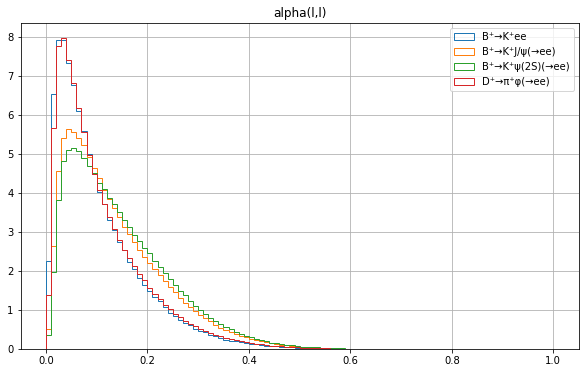

In [26]:
for idx in range(4):
    plt.hist(truthed[idx]['angle_ee_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 1.0, 101), histtype='step')
plt.title('alpha(l,l)')
plt.legend()
plt.grid()
plt.show()

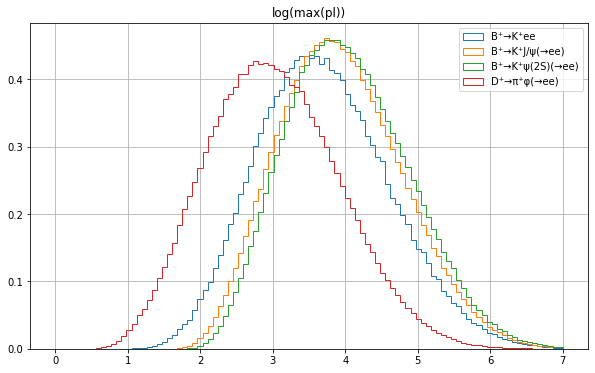

In [27]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['log_max_pl'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 7, 101), histtype='step')
plt.title(r'log(max(pl))')
plt.legend()
plt.grid()
plt.show()

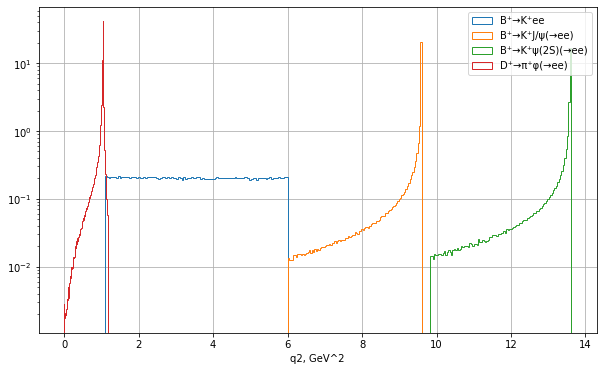

In [28]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['q2_TRUE'], label="%s"%df_index[idx],
             density=True, bins=100, histtype='step', log=True)
plt.xlabel(r'q2, GeV^2')
plt.legend()
plt.grid()
plt.show()

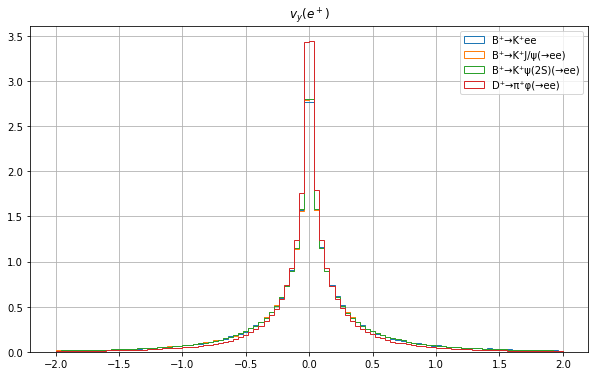

In [29]:
for idx in range(4):
    data = truthed[idx]
    plt.hist(data['ep_origY_TRUE'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(-2,2,101), histtype='step')
plt.title(r'$v_y(e^+)$')
plt.legend()
plt.grid()
plt.show()

### Preprocessing

In [30]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [31]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    mapping = dict()
    for i, ix in enumerate(idx):
        try:
            x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        except KeyError:
            x_ = np.ones((len(truthed[ix][list(truthed[ix].keys())[0]]), len(fnames))) * np.nan
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
        mapping[i] = ix
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y, mapping

In [32]:
class Dataset():
    def __init__(self, features, idx):
        self.features = features
        self.indices = idx
        X, Y, mapping = make_dataset(features, idx)
        x_train, x_test, y_train, y_test = \
            sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)
        self.X = X
        self.Y = Y
        self.mapping = mapping
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(x_train)
        self.counts = np.asarray([np.sum(y_train==label) for label in sorted(mapping.keys())])
        self.weights = y_train.shape[0]/self.counts/self.counts.shape[0]
    def torch_dataset(self):
        dataset = torch.utils.data.TensorDataset(
            from_numpy(self.scaler.transform(self.x_train)),
            from_numpy(self.y_train, dtype=torch.long)
        )
        return dataset

In [33]:
def plot_ds(dataset):
    for label in sorted(dataset.mapping.keys()):
        idx = dataset.y_train==label
        x = dataset.x_train[idx][:10000,0:2]
        plt.scatter(*(x.T), marker=".", s=0.1, label="%s"%df_index[dataset.mapping[label]])
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-2*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(2*ones)[0,0:2]
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.gca().set_aspect(1.0/plt.gca().get_data_ratio(), adjustable='box')
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    plt.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    plt.grid()
    plt.show()

In [34]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

### NN

In [35]:
def model(inputs=2, outputs=4):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [36]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [37]:
def plot_field(f, dataset, name=None, save=None, vmin=0.0, vmax=1.0):
    ones = np.ones_like(dataset.x_train[0:1])
    x_min, y_min = dataset.scaler.inverse_transform(-3*ones)[0,0:2]
    x_max, y_max = dataset.scaler.inverse_transform(3*ones)[0,0:2]
    X_test = np.random.rand(3000000, 2) * [x_max-x_min, y_max-y_min] + [x_min, y_min]
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(dataset.features[0])
    plt.ylabel(dataset.features[1])
    plt.grid()
    plt.gca().set_aspect(1.0/plt.gca().get_data_ratio(), adjustable='box')
    if name is not None:
        plt.title(name)
    if save is not None:
        plt.savefig(save)
    plt.show()

In [38]:
def plot_clf(ds, clf, c0, c1):
    fn = lambda x : x[:,c1] - x[:,c0]
    f = lambda x : to_numpy(torch.sigmoid(fn(clf(from_numpy(ds.scaler.transform(x))))))
    plot_field(f, ds, r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]]))

In [39]:
def plot_clf_min_max(ds, clf):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : to_numpy(torch.relu(torch.min(fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    f_max = lambda x : to_numpy(torch.relu(torch.min(-fn(clf(from_numpy(ds.scaler.transform(x)))), dim=-1)[0]))
    plot_field(f_min, ds, r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$', vmax=None)
    plot_field(f_max, ds, r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$', vmax=None)

In [40]:
class Estimator():
    def __init__(self, features, idx):
        self.ds = Dataset(features, idx)
        self.model = model(len(features), len(list(idx))).to(device)
    def train(self):
        dataset = self.ds.torch_dataset()
        loader = Loader(dataset, batch_size=100000, shuffle=True, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=False)
        loader = Loader(dataset, batch_size=100000, shuffle=False, device=device)
        train(self.model, loader, epochs=50, weight=self.ds.weights, accumulate=True)
        return self.model

In [41]:
%%time
e_a4 = Estimator(["alpha"], range(4))
e_a4.train()

INFO:root:Epoch 0, 1.462524
INFO:root:Epoch 1, 1.388312
INFO:root:Epoch 2, 1.385243
INFO:root:Epoch 3, 1.383136
INFO:root:Epoch 4, 1.380228
INFO:root:Epoch 5, 1.376304
INFO:root:Epoch 6, 1.372705
INFO:root:Epoch 7, 1.370465
INFO:root:Epoch 8, 1.369251
INFO:root:Epoch 9, 1.368473
INFO:root:Epoch 10, 1.367820
INFO:root:Epoch 11, 1.367232
INFO:root:Epoch 12, 1.366693
INFO:root:Epoch 13, 1.366218
INFO:root:Epoch 14, 1.365798
INFO:root:Epoch 15, 1.365437
INFO:root:Epoch 16, 1.365145
INFO:root:Epoch 17, 1.364910
INFO:root:Epoch 18, 1.364728
INFO:root:Epoch 19, 1.364576
INFO:root:Epoch 20, 1.364465
INFO:root:Epoch 21, 1.364375
INFO:root:Epoch 22, 1.364291
INFO:root:Epoch 23, 1.364236
INFO:root:Epoch 24, 1.364183
INFO:root:Epoch 25, 1.364144
INFO:root:Epoch 26, 1.364108
INFO:root:Epoch 27, 1.364080
INFO:root:Epoch 28, 1.364051
INFO:root:Epoch 29, 1.364034
INFO:root:Epoch 30, 1.364018
INFO:root:Epoch 31, 1.363971
INFO:root:Epoch 32, 1.363952
INFO:root:Epoch 33, 1.363931
INFO:root:Epoch 34, 1.36

CPU times: user 36.4 s, sys: 4.38 s, total: 40.8 s
Wall time: 40.7 s


Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [42]:
%%time
e_a3 = Estimator(["alpha"], range(3))
e_a3.train()

INFO:root:Epoch 0, 1.165274
INFO:root:Epoch 1, 1.099159
INFO:root:Epoch 2, 1.095092
INFO:root:Epoch 3, 1.091428
INFO:root:Epoch 4, 1.087216
INFO:root:Epoch 5, 1.082835
INFO:root:Epoch 6, 1.080361
INFO:root:Epoch 7, 1.079399
INFO:root:Epoch 8, 1.078807
INFO:root:Epoch 9, 1.078334
INFO:root:Epoch 10, 1.077944
INFO:root:Epoch 11, 1.077636
INFO:root:Epoch 12, 1.077392
INFO:root:Epoch 13, 1.077176
INFO:root:Epoch 14, 1.077031
INFO:root:Epoch 15, 1.076897
INFO:root:Epoch 16, 1.076787
INFO:root:Epoch 17, 1.076741
INFO:root:Epoch 18, 1.076643
INFO:root:Epoch 19, 1.076594
INFO:root:Epoch 20, 1.076558
INFO:root:Epoch 21, 1.076504
INFO:root:Epoch 22, 1.076477
INFO:root:Epoch 23, 1.076467
INFO:root:Epoch 24, 1.076406
INFO:root:Epoch 25, 1.076395
INFO:root:Epoch 26, 1.076352
INFO:root:Epoch 27, 1.076314
INFO:root:Epoch 28, 1.076287
INFO:root:Epoch 29, 1.076267
INFO:root:Epoch 30, 1.076233
INFO:root:Epoch 31, 1.076205
INFO:root:Epoch 32, 1.076181
INFO:root:Epoch 33, 1.076166
INFO:root:Epoch 34, 1.07

CPU times: user 25.7 s, sys: 1.69 s, total: 27.4 s
Wall time: 27.3 s


Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

In [43]:
%%time
e_la = Estimator(["alpha", "log_max_pl"], range(4))
e_la.train()

INFO:root:Epoch 0, 1.404171
INFO:root:Epoch 1, 1.369603
INFO:root:Epoch 2, 1.339156
INFO:root:Epoch 3, 1.273775
INFO:root:Epoch 4, 1.163830
INFO:root:Epoch 5, 1.068056
INFO:root:Epoch 6, 1.030521
INFO:root:Epoch 7, 1.009760
INFO:root:Epoch 8, 0.985549
INFO:root:Epoch 9, 0.956093
INFO:root:Epoch 10, 0.925765
INFO:root:Epoch 11, 0.904301
INFO:root:Epoch 12, 0.892137
INFO:root:Epoch 13, 0.884194
INFO:root:Epoch 14, 0.877854
INFO:root:Epoch 15, 0.871966
INFO:root:Epoch 16, 0.866370
INFO:root:Epoch 17, 0.861117
INFO:root:Epoch 18, 0.856195
INFO:root:Epoch 19, 0.851797
INFO:root:Epoch 20, 0.847858
INFO:root:Epoch 21, 0.844511
INFO:root:Epoch 22, 0.841597
INFO:root:Epoch 23, 0.839118
INFO:root:Epoch 24, 0.836953
INFO:root:Epoch 25, 0.835025
INFO:root:Epoch 26, 0.833304
INFO:root:Epoch 27, 0.831825
INFO:root:Epoch 28, 0.830314
INFO:root:Epoch 29, 0.828933
INFO:root:Epoch 30, 0.827659
INFO:root:Epoch 31, 0.826505
INFO:root:Epoch 32, 0.825463
INFO:root:Epoch 33, 0.824474
INFO:root:Epoch 34, 0.82

CPU times: user 37 s, sys: 4.2 s, total: 41.2 s
Wall time: 41.1 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

In [44]:
%%time
e_la3 = Estimator(["alpha", "log_max_pl"], range(3))
e_la3.train()

INFO:root:Epoch 0, 1.109754
INFO:root:Epoch 1, 1.093732
INFO:root:Epoch 2, 1.085054
INFO:root:Epoch 3, 1.069495
INFO:root:Epoch 4, 1.041300
INFO:root:Epoch 5, 1.007805
INFO:root:Epoch 6, 0.980126
INFO:root:Epoch 7, 0.956307
INFO:root:Epoch 8, 0.937378
INFO:root:Epoch 9, 0.919263
INFO:root:Epoch 10, 0.901333
INFO:root:Epoch 11, 0.887382
INFO:root:Epoch 12, 0.879105
INFO:root:Epoch 13, 0.873461
INFO:root:Epoch 14, 0.869187
INFO:root:Epoch 15, 0.865184
INFO:root:Epoch 16, 0.862003
INFO:root:Epoch 17, 0.858522
INFO:root:Epoch 18, 0.855314
INFO:root:Epoch 19, 0.852138
INFO:root:Epoch 20, 0.848913
INFO:root:Epoch 21, 0.845779
INFO:root:Epoch 22, 0.842485
INFO:root:Epoch 23, 0.839351
INFO:root:Epoch 24, 0.836246
INFO:root:Epoch 25, 0.833046
INFO:root:Epoch 26, 0.830273
INFO:root:Epoch 27, 0.827289
INFO:root:Epoch 28, 0.824373
INFO:root:Epoch 29, 0.821843
INFO:root:Epoch 30, 0.819224
INFO:root:Epoch 31, 0.816783
INFO:root:Epoch 32, 0.814477
INFO:root:Epoch 33, 0.812543
INFO:root:Epoch 34, 0.81

CPU times: user 27 s, sys: 1.95 s, total: 29 s
Wall time: 28.9 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

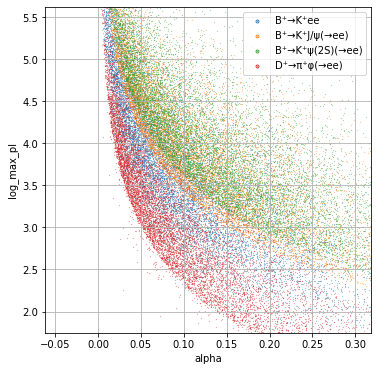

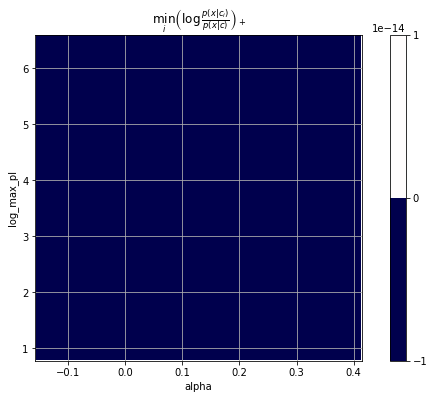

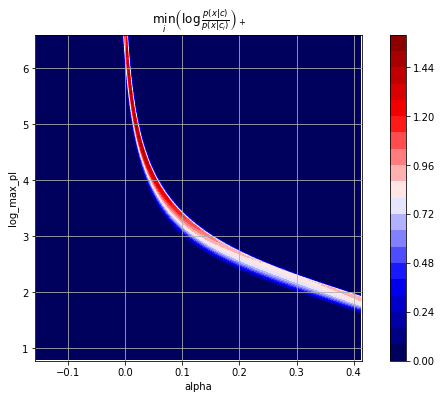

In [45]:
plot_ds(e_la.ds)
plot_clf_min_max(e_la.ds, e_la.model)

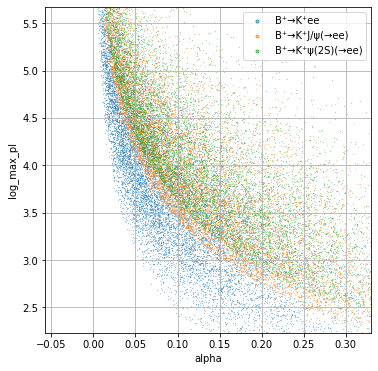

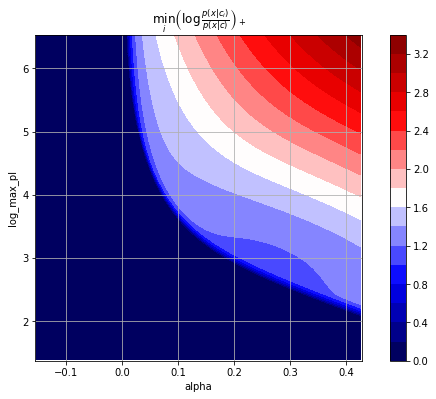

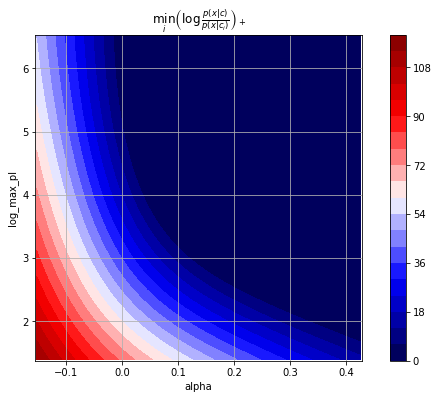

In [46]:
plot_ds(e_la3.ds)
plot_clf_min_max(e_la3.ds, e_la3.model)

In [47]:
%%time
e_ptpt = Estimator(["log_ep_PT", "log_em_PT"], range(4))
e_ptpt.train()

INFO:root:Epoch 0, 1.497295
INFO:root:Epoch 1, 1.370748
INFO:root:Epoch 2, 1.325250
INFO:root:Epoch 3, 1.239176
INFO:root:Epoch 4, 1.137122
INFO:root:Epoch 5, 1.093417
INFO:root:Epoch 6, 1.082087
INFO:root:Epoch 7, 1.075982
INFO:root:Epoch 8, 1.071315
INFO:root:Epoch 9, 1.067622
INFO:root:Epoch 10, 1.064694
INFO:root:Epoch 11, 1.062439
INFO:root:Epoch 12, 1.060677
INFO:root:Epoch 13, 1.059303
INFO:root:Epoch 14, 1.058215
INFO:root:Epoch 15, 1.057338
INFO:root:Epoch 16, 1.056636
INFO:root:Epoch 17, 1.056105
INFO:root:Epoch 18, 1.055650
INFO:root:Epoch 19, 1.055280
INFO:root:Epoch 20, 1.054991
INFO:root:Epoch 21, 1.054737
INFO:root:Epoch 22, 1.054502
INFO:root:Epoch 23, 1.054294
INFO:root:Epoch 24, 1.054098
INFO:root:Epoch 25, 1.053935
INFO:root:Epoch 26, 1.053735
INFO:root:Epoch 27, 1.053473
INFO:root:Epoch 28, 1.053266
INFO:root:Epoch 29, 1.053033
INFO:root:Epoch 30, 1.052729
INFO:root:Epoch 31, 1.052473
INFO:root:Epoch 32, 1.052131
INFO:root:Epoch 33, 1.051768
INFO:root:Epoch 34, 1.05

CPU times: user 36.9 s, sys: 4.37 s, total: 41.3 s
Wall time: 41.1 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=4, bias=True)
)

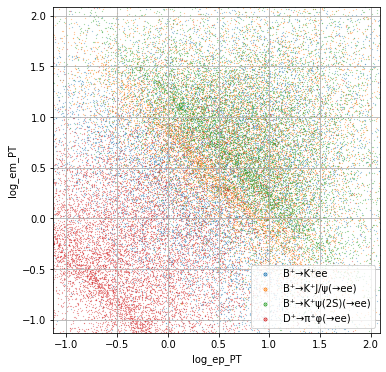

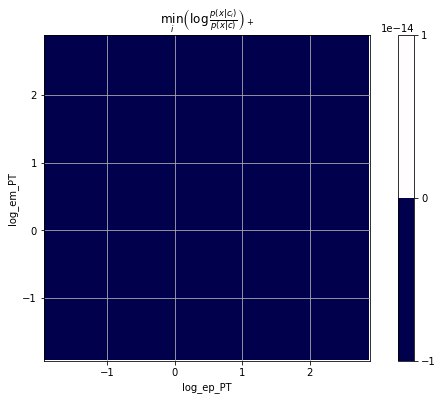

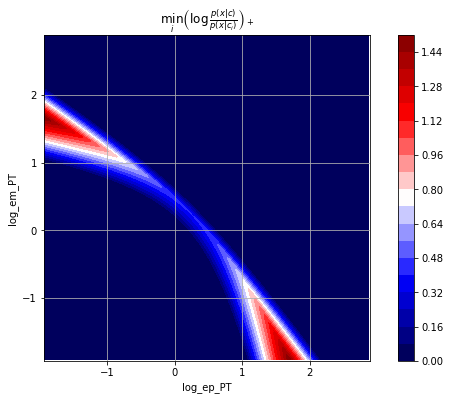

In [48]:
plot_ds(e_ptpt.ds)
plot_clf_min_max(e_ptpt.ds, e_ptpt.model)

In [49]:
%%time
e_ptpt3 = Estimator(["log_ep_PT", "log_em_PT"], range(3))
e_ptpt3.train()

INFO:root:Epoch 0, 1.100258
INFO:root:Epoch 1, 1.095185
INFO:root:Epoch 2, 1.089575
INFO:root:Epoch 3, 1.078244
INFO:root:Epoch 4, 1.060599
INFO:root:Epoch 5, 1.047936
INFO:root:Epoch 6, 1.039536
INFO:root:Epoch 7, 1.032683
INFO:root:Epoch 8, 1.026910
INFO:root:Epoch 9, 1.022095
INFO:root:Epoch 10, 1.017928
INFO:root:Epoch 11, 1.014634
INFO:root:Epoch 12, 1.012002
INFO:root:Epoch 13, 1.010158
INFO:root:Epoch 14, 1.008905
INFO:root:Epoch 15, 1.007733
INFO:root:Epoch 16, 1.006980
INFO:root:Epoch 17, 1.006408
INFO:root:Epoch 18, 1.005976
INFO:root:Epoch 19, 1.005666
INFO:root:Epoch 20, 1.005273
INFO:root:Epoch 21, 1.005112
INFO:root:Epoch 22, 1.004883
INFO:root:Epoch 23, 1.004611
INFO:root:Epoch 24, 1.004286
INFO:root:Epoch 25, 1.003945
INFO:root:Epoch 26, 1.003690
INFO:root:Epoch 27, 1.003637
INFO:root:Epoch 28, 1.003350
INFO:root:Epoch 29, 1.002952
INFO:root:Epoch 30, 1.002712
INFO:root:Epoch 31, 1.002455
INFO:root:Epoch 32, 1.002245
INFO:root:Epoch 33, 1.002031
INFO:root:Epoch 34, 1.00

CPU times: user 27.4 s, sys: 2.07 s, total: 29.5 s
Wall time: 29.3 s


Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=20, out_features=3, bias=True)
)

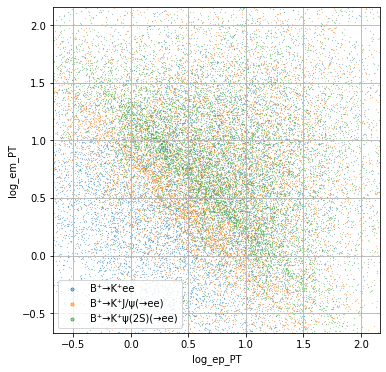

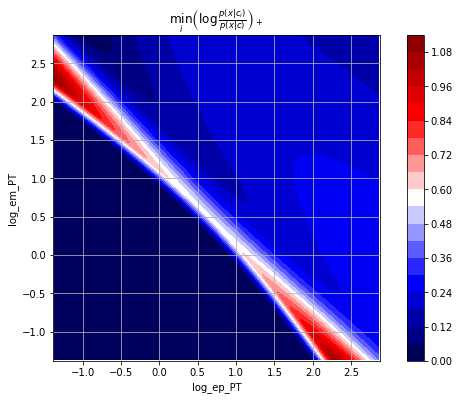

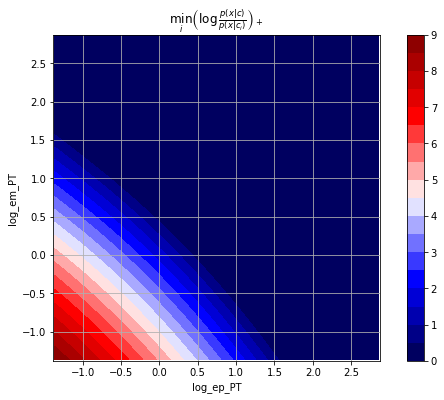

In [50]:
plot_ds(e_ptpt3.ds)
plot_clf_min_max(e_ptpt3.ds, e_ptpt3.model)

### Crafting a loss

In [51]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

In [52]:
def compute_lipschitz(model, loader, device=device):
    model.eval()
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        x.requires_grad = True
        model.zero_grad()
        fx = model(x)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x.grad.norm(dim=1)).item())
    return L

In [53]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [54]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = torch.softmax(model(x), dim=-1) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [55]:
@torch.no_grad()
def make_weighting(model, loader, selected_class, n_outs, n_classes):
    W = to_numpy(create_w(model, loader, n_outs, n_classes)[0])
    print(W)
    print("|W| = ", np.linalg.det(W))
    Wpinv = np.linalg.pinv(W) # n*N
    print(Wpinv)
    w0 = Wpinv[selected_class]
    m_minus = np.max(-w0)
    m_plus = np.max(w0,0)
    m_sum = m_minus + m_plus
    k = np.maximum(m_minus*50, m_plus*50/49)
    #linear.weight.data = from_numpy((w0 + m_minus)/m_sum).view(1, n_outs)
    #estimate = 1+1/(m_plus-1) # R_K
    linear = torch.nn.Linear(W.shape[0], 1, bias=False)
    linear.weight.data = from_numpy((w0 + k/50)/k).view(1, n_outs)
    #linear.weight.data = from_numpy((w0 + m_minus)/m_sum)
    estimate = (k*0.98)/(k*0.98-1) # R_K
    print("R_K", estimate)
    print(linear.weight.data)
    return nn.Sequential(model, torch.nn.Softmax(dim=-1), linear)

In [57]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    res = torch.nn.Sequential(
        torch.nn.Sequential(
            model,
            torch.nn.Softmax(dim=-1),
        ),
        torch.nn.Linear(n_outs, 1, bias=False),
    ).to(device)
    tmp = clone_model(res)
    opt = torch.optim.SGD(params=model.parameters(), lr=1e-4)
    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    
    for epoch in range(epochs):
        model.eval()
        with torch.no_grad():
            W, counts = create_w(model, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        det = np.linalg.det(W_np)
        W_pinv_ = from_numpy(W_pinv)
        W_pinv_T = W_pinv_.T
        
        w0 = W_pinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus/0.02, m_plus/(1-0.02))
        #res[1].weight.data = from_numpy((w0 + m_minus)/m_sum).view(1, n_outs)
        #estimate = 1+1/(m_plus-1) # R_K
        res[1].weight.data = from_numpy((w0 + k*0.02)/k).view(1, n_outs)
        estimate = (k*0.98)/(k*0.98-1) # R_K

        
        wcj = W_pinv[selected_class]                   # N
        wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
        #ix_min = np.argmin(wcj)
        #ix_max = np.argmax(wcj)
        #wcj_ = np.zeros(n_outs)
        #if m_minus * 49 > m_plus:
        #    wcj_[ix_min] = 1
        #else:
        #    wcj_[ix_max] = -1
        #wcj_[ix_min] = 0.98
        #wcj_[ix_max] = -0.02
        #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
        wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
        W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
        W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
        W_m_t = from_numpy(W_m_)
        
        for tmp_par, res_par in zip(tmp.parameters(), res.parameters()): 
            tmp_par.data.copy_(res_par.data)
        #tmp.load_state_dict(res.state_dict())
        
        model.train()
        opt.zero_grad()
        total_loss = 0    
        L = 0
        for batch in loader:
            x, y = batch
            
            y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
            pred = res[0](x)
            
            wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
            W = wsum/counts
            
            loss_c = torch.sum(W*W_m_t)
            loss_d = -torch.sum(W*W_pinv_T)
            loss = loss_d + alpha * loss_c
            total_loss += loss
            loss.backward()
            
            # Lipschitz part of the loss
            
            x.requires_grad = True
            tmp.zero_grad()
            fx = tmp(x)
            L_loss = torch.sum(fx)
            L_loss.backward()
            dx = x.grad
            L = max(L, torch.max(dx.norm(dim=1)).item())
            x.requires_grad = False
            
            if target_L is not None:
                ext_dx = dx[None,...] * dx_ # 2*B*n_features
                ext_x = x[None,...] + ext_dx

                pred_dfx = res(ext_x) # 2*B*N
                dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                total_loss += loss_L
                loss_L.backward()
                        
        opt.step()
        #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
        print("Epoch %d loss=%f est=%f W+c=%s det=%f L=%f" % (epoch, total_loss, estimate, W_pinv[selected_class], det, L))
    res.eval()
    res.zero_grad(set_to_none=True)
    return res

In [58]:
class Weighting():
    def __init__(self, estimator):
        N = len(list(estimator.ds.indices))
        self.estimator = estimator
        self.model = model(len(estimator.ds.features), N).to(device)
        self.model.load_state_dict(estimator.model.state_dict())
        self.n_outs = N
        self.n_classes = N
    def train(self, **kwargs):
        self.w_model_ = None
        loader = Loader(self.estimator.ds.torch_dataset(), batch_size=100000, shuffle=False, device=device)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=200, alpha=0.001)
        train_pinv(self.model, loader, self.n_outs, self.n_classes, 0, epochs=500, alpha=300, **kwargs)
        return self.w_model()
    def w_model(self):
        if self.w_model_ is None:
            loader = Loader(self.estimator.ds.torch_dataset(), batch_size=100000, shuffle=False, device=device)
            self.w_model_ = make_weighting(self.model, loader, 0, self.n_outs, self.n_classes)
        return self.w_model_
    def w_model_np(self):
        fn = self.w_model()
        fn_np = lambda x : to_numpy(fn(from_numpy(self.estimator.ds.scaler.transform(x))))
        return fn_np
    def dataset(self):
        return self.estimator.ds

In [59]:
%%time
w_la = Weighting(e_la)
w_la.train(target_L=0.1)

Epoch 0 loss=-4.000084 est=1.004940 W+c=[ 4.6198 -4.1517  2.0674 -1.5985] det=0.007038 L=0.259736
Epoch 1 loss=-4.000083 est=1.004957 W+c=[ 4.6196 -4.1375  2.0169 -1.5968] det=0.007124 L=0.260306
Epoch 2 loss=-4.000085 est=1.004974 W+c=[ 4.6193 -4.1234  1.9686 -1.5952] det=0.007209 L=0.260882
Epoch 3 loss=-4.000085 est=1.004991 W+c=[ 4.619  -4.1095  1.9224 -1.5936] det=0.007293 L=0.261466
Epoch 4 loss=-4.000083 est=1.005008 W+c=[ 4.6185 -4.0957  1.8781 -1.5921] det=0.007375 L=0.262057
Epoch 5 loss=-4.000084 est=1.005025 W+c=[ 4.618  -4.082   1.8357 -1.5906] det=0.007456 L=0.262655
Epoch 6 loss=-4.000084 est=1.005041 W+c=[ 4.6174 -4.0684  1.7949 -1.5891] det=0.007536 L=0.263260
Epoch 7 loss=-4.000084 est=1.005058 W+c=[ 4.6167 -4.055   1.7559 -1.5877] det=0.007615 L=0.263873
Epoch 8 loss=-4.000082 est=1.005075 W+c=[ 4.616  -4.0417  1.7183 -1.5864] det=0.007692 L=0.264493
Epoch 9 loss=-4.000082 est=1.005092 W+c=[ 4.6152 -4.0285  1.6823 -1.5851] det=0.007768 L=0.265120
Epoch 10 loss=-4.000

Epoch 83 loss=-4.000084 est=1.006415 W+c=[ 4.4718 -3.2019  0.6621 -1.5441] det=0.011544 L=0.324358
Epoch 84 loss=-4.000084 est=1.006434 W+c=[ 4.4694 -3.1924  0.657  -1.5438] det=0.011582 L=0.325245
Epoch 85 loss=-4.000084 est=1.006453 W+c=[ 4.467  -3.1829  0.652  -1.5436] det=0.011620 L=0.326133
Epoch 86 loss=-4.000084 est=1.006473 W+c=[ 4.4646 -3.1734  0.6471 -1.5434] det=0.011658 L=0.327022
Epoch 87 loss=-4.000084 est=1.006492 W+c=[ 4.4622 -3.164   0.6422 -1.5431] det=0.011696 L=0.327911
Epoch 88 loss=-4.000083 est=1.006511 W+c=[ 4.4598 -3.1546  0.6375 -1.5429] det=0.011733 L=0.328801
Epoch 89 loss=-4.000082 est=1.006531 W+c=[ 4.4574 -3.1453  0.6328 -1.5427] det=0.011771 L=0.329691
Epoch 90 loss=-4.000083 est=1.006550 W+c=[ 4.455  -3.136   0.6282 -1.5425] det=0.011808 L=0.330581
Epoch 91 loss=-4.000083 est=1.006570 W+c=[ 4.4526 -3.1267  0.6237 -1.5423] det=0.011845 L=0.331472
Epoch 92 loss=-4.000083 est=1.006589 W+c=[ 4.4502 -3.1175  0.6192 -1.5421] det=0.011882 L=0.332363
Epoch 93 l

Epoch 166 loss=-4.000084 est=1.008103 W+c=[ 4.2771 -2.5391  0.4147 -1.5296] det=0.014344 L=0.396427
Epoch 167 loss=-4.000084 est=1.008124 W+c=[ 4.2749 -2.5326  0.4129 -1.5295] det=0.014374 L=0.397243
Epoch 168 loss=-4.000083 est=1.008145 W+c=[ 4.2727 -2.526   0.4112 -1.5293] det=0.014405 L=0.398057
Epoch 169 loss=-4.000084 est=1.008166 W+c=[ 4.2705 -2.5195  0.4095 -1.5292] det=0.014435 L=0.398869
Epoch 170 loss=-4.000084 est=1.008187 W+c=[ 4.2683 -2.5131  0.4078 -1.529 ] det=0.014466 L=0.399679
Epoch 171 loss=-4.000084 est=1.008208 W+c=[ 4.2661 -2.5066  0.4062 -1.5289] det=0.014496 L=0.400487
Epoch 172 loss=-4.000084 est=1.008230 W+c=[ 4.2639 -2.5002  0.4045 -1.5287] det=0.014526 L=0.401293
Epoch 173 loss=-4.000084 est=1.008251 W+c=[ 4.2617 -2.4938  0.4029 -1.5286] det=0.014557 L=0.402098
Epoch 174 loss=-4.000083 est=1.008272 W+c=[ 4.2596 -2.4875  0.4013 -1.5284] det=0.014587 L=0.402900
Epoch 175 loss=-4.000084 est=1.008293 W+c=[ 4.2574 -2.4812  0.3997 -1.5283] det=0.014617 L=0.403701


Epoch 49 loss=-4.532549 est=1.015194 W+c=[66.816  -1.027   0.5274 -0.7154] det=0.001695 L=1.126972
Epoch 50 loss=-4.624148 est=1.014890 W+c=[68.1587 -1.0302  0.5202 -0.7161] det=0.001671 L=1.104989
Epoch 51 loss=-4.683607 est=1.014688 W+c=[69.0845 -1.0308  0.512  -0.7173] det=0.001658 L=1.089642
Epoch 52 loss=-4.724373 est=1.014550 W+c=[69.7276 -1.0297  0.5033 -0.7187] det=0.001651 L=1.078590
Epoch 53 loss=-4.753423 est=1.014457 W+c=[70.1718 -1.0275  0.4943 -0.7203] det=0.001649 L=1.070425
Epoch 54 loss=-4.774726 est=1.014394 W+c=[70.4721 -1.0245  0.4852 -0.7221] det=0.001651 L=1.064309
Epoch 55 loss=-4.790711 est=1.014354 W+c=[70.6669 -1.0209  0.4762 -0.7239] det=0.001655 L=1.059742
Epoch 56 loss=-4.802939 est=1.014330 W+c=[70.7832 -1.017   0.4673 -0.7258] det=0.001660 L=1.056239
Epoch 57 loss=-4.812460 est=1.014318 W+c=[70.8408 -1.0129  0.4585 -0.7277] det=0.001666 L=1.053539
Epoch 58 loss=-4.819993 est=1.014316 W+c=[70.8541 -1.0086  0.45   -0.7296] det=0.001674 L=1.051495
Epoch 59 l

Epoch 132 loss=-4.965076 est=1.015944 W+c=[63.7179 -0.7868  0.1851 -0.8499] det=0.002198 L=1.055041
Epoch 133 loss=-4.967001 est=1.015965 W+c=[63.6373 -0.7849  0.1837 -0.8513] det=0.002203 L=1.055219
Epoch 134 loss=-4.968931 est=1.015985 W+c=[63.5572 -0.7831  0.1824 -0.8527] det=0.002209 L=1.055391
Epoch 135 loss=-4.970869 est=1.016006 W+c=[63.4776 -0.7812  0.181  -0.8541] det=0.002214 L=1.055563
Epoch 136 loss=-4.972806 est=1.016026 W+c=[63.3984 -0.7794  0.1797 -0.8554] det=0.002219 L=1.055742
Epoch 137 loss=-4.974748 est=1.016046 W+c=[63.3196 -0.7776  0.1784 -0.8568] det=0.002224 L=1.055915
Epoch 138 loss=-4.976693 est=1.016067 W+c=[63.2413 -0.7759  0.1772 -0.8582] det=0.002229 L=1.056085
Epoch 139 loss=-4.978642 est=1.016087 W+c=[63.1634 -0.7741  0.176  -0.8596] det=0.002234 L=1.056249
Epoch 140 loss=-4.980594 est=1.016107 W+c=[63.086  -0.7724  0.1747 -0.8609] det=0.002239 L=1.056410
Epoch 141 loss=-4.982550 est=1.016127 W+c=[63.0089 -0.7706  0.1735 -0.8623] det=0.002244 L=1.056566


Epoch 214 loss=-5.127298 est=1.017430 W+c=[58.3711 -0.68    0.1213 -0.9508] det=0.002543 L=1.063222
Epoch 215 loss=-5.129228 est=1.017446 W+c=[58.3193 -0.6792  0.1209 -0.9519] det=0.002547 L=1.063244
Epoch 216 loss=-5.131157 est=1.017462 W+c=[58.2678 -0.6783  0.1204 -0.9529] det=0.002550 L=1.063264
Epoch 217 loss=-5.133082 est=1.017477 W+c=[58.2166 -0.6774  0.12   -0.954 ] det=0.002554 L=1.063281
Epoch 218 loss=-5.135004 est=1.017493 W+c=[58.1656 -0.6766  0.1196 -0.955 ] det=0.002557 L=1.063296
Epoch 219 loss=-5.136921 est=1.017509 W+c=[58.115  -0.6758  0.1193 -0.956 ] det=0.002560 L=1.063309
Epoch 220 loss=-5.138838 est=1.017524 W+c=[58.0646 -0.6749  0.1189 -0.9571] det=0.002564 L=1.063319
Epoch 221 loss=-5.140747 est=1.017539 W+c=[58.0144 -0.6741  0.1185 -0.9581] det=0.002567 L=1.063327
Epoch 222 loss=-5.142655 est=1.017555 W+c=[57.9646 -0.6733  0.1181 -0.9591] det=0.002570 L=1.063339
Epoch 223 loss=-5.144560 est=1.017570 W+c=[57.915  -0.6725  0.1177 -0.9601] det=0.002574 L=1.063352


Epoch 296 loss=-5.270168 est=1.018538 W+c=[54.9428 -0.628   0.0995 -1.0214] det=0.002777 L=1.060942
Epoch 297 loss=-5.271677 est=1.018549 W+c=[54.91   -0.6276  0.0993 -1.0221] det=0.002779 L=1.060881
Epoch 298 loss=-5.273179 est=1.018561 W+c=[54.8773 -0.6271  0.0991 -1.0228] det=0.002781 L=1.060817
Epoch 299 loss=-5.274676 est=1.018572 W+c=[54.8448 -0.6267  0.099  -1.0234] det=0.002784 L=1.060752
Epoch 300 loss=-5.276165 est=1.018583 W+c=[54.8125 -0.6262  0.0988 -1.0241] det=0.002786 L=1.060685
Epoch 301 loss=-5.277649 est=1.018594 W+c=[54.7804 -0.6258  0.0987 -1.0247] det=0.002788 L=1.060616
Epoch 302 loss=-5.279126 est=1.018605 W+c=[54.7484 -0.6253  0.0985 -1.0254] det=0.002790 L=1.060544
Epoch 303 loss=-5.280599 est=1.018616 W+c=[54.7167 -0.6249  0.0984 -1.026 ] det=0.002793 L=1.060472
Epoch 304 loss=-5.282061 est=1.018627 W+c=[54.6851 -0.6245  0.0982 -1.0266] det=0.002795 L=1.060397
Epoch 305 loss=-5.283522 est=1.018638 W+c=[54.6537 -0.624   0.0981 -1.0273] det=0.002797 L=1.060321


Epoch 378 loss=-5.373894 est=1.019312 W+c=[52.78   -0.5979  0.0904 -1.0628] det=0.002937 L=1.054221
Epoch 379 loss=-5.374927 est=1.019320 W+c=[52.7593 -0.5976  0.0903 -1.0632] det=0.002938 L=1.054132
Epoch 380 loss=-5.375953 est=1.019328 W+c=[52.7386 -0.5973  0.0903 -1.0636] det=0.002940 L=1.054044
Epoch 381 loss=-5.376975 est=1.019336 W+c=[52.7181 -0.597   0.0902 -1.0639] det=0.002942 L=1.053956
Epoch 382 loss=-5.377991 est=1.019343 W+c=[52.6977 -0.5967  0.0901 -1.0643] det=0.002943 L=1.053867
Epoch 383 loss=-5.379004 est=1.019351 W+c=[52.6774 -0.5964  0.09   -1.0646] det=0.002945 L=1.053776
Epoch 384 loss=-5.380011 est=1.019358 W+c=[52.6572 -0.5961  0.09   -1.065 ] det=0.002946 L=1.053684
Epoch 385 loss=-5.381010 est=1.019366 W+c=[52.6371 -0.5958  0.0899 -1.0653] det=0.002948 L=1.053592
Epoch 386 loss=-5.382009 est=1.019373 W+c=[52.6171 -0.5955  0.0898 -1.0657] det=0.002949 L=1.053498
Epoch 387 loss=-5.382999 est=1.019381 W+c=[52.5972 -0.5952  0.0898 -1.066 ] det=0.002951 L=1.053403


Epoch 460 loss=-8.453116 est=1.016969 W+c=[20.3667 -0.3993  0.0717 -1.2231] det=0.007438 L=0.804493
Epoch 461 loss=-8.521710 est=1.017009 W+c=[20.0006 -0.3982  0.072  -1.2202] det=0.007569 L=0.805102
Epoch 462 loss=-8.587443 est=1.017055 W+c=[19.6553 -0.3974  0.0724 -1.217 ] det=0.007696 L=0.806118
Epoch 463 loss=-8.650217 est=1.017106 W+c=[19.3298 -0.3966  0.0727 -1.2135] det=0.007819 L=0.807524
Epoch 464 loss=-8.709931 est=1.017162 W+c=[19.0234 -0.396   0.0731 -1.2096] det=0.007940 L=0.809302
Epoch 465 loss=-8.766519 est=1.017222 W+c=[18.7351 -0.3955  0.0735 -1.2054] det=0.008057 L=0.811432
Epoch 466 loss=-8.819901 est=1.017286 W+c=[18.4642 -0.3951  0.0739 -1.201 ] det=0.008170 L=0.813895
Epoch 467 loss=-8.870039 est=1.017355 W+c=[18.2098 -0.3948  0.0743 -1.1963] det=0.008279 L=0.816678
Epoch 468 loss=-8.916857 est=1.017426 W+c=[17.9712 -0.3946  0.0748 -1.1915] det=0.008385 L=0.819761
Epoch 469 loss=-8.960326 est=1.017501 W+c=[17.7477 -0.3945  0.0753 -1.1865] det=0.008486 L=0.823128


Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [60]:
%%time
w_la3 = Weighting(e_la3)
w_la3.train(target_L=0.1)

Epoch 0 loss=-3.000074 est=1.009302 W+c=[ 1.9166 -2.2143  1.2918] det=0.022043 L=0.151338
Epoch 1 loss=-3.000074 est=1.009342 W+c=[ 1.9171 -2.205   1.2848] det=0.022101 L=0.151939
Epoch 2 loss=-3.000074 est=1.009382 W+c=[ 1.9177 -2.1958  1.2779] det=0.022159 L=0.152540
Epoch 3 loss=-3.000076 est=1.009421 W+c=[ 1.9182 -2.1866  1.2711] det=0.022216 L=0.153141
Epoch 4 loss=-3.000075 est=1.009461 W+c=[ 1.9188 -2.1776  1.2643] det=0.022274 L=0.153741
Epoch 5 loss=-3.000076 est=1.009500 W+c=[ 1.9193 -2.1686  1.2576] det=0.022331 L=0.154341
Epoch 6 loss=-3.000077 est=1.009540 W+c=[ 1.9198 -2.1597  1.2509] det=0.022388 L=0.154941
Epoch 7 loss=-3.000076 est=1.009579 W+c=[ 1.9204 -2.1509  1.2443] det=0.022445 L=0.155541
Epoch 8 loss=-3.000075 est=1.009618 W+c=[ 1.9209 -2.1422  1.2378] det=0.022502 L=0.156141
Epoch 9 loss=-3.000077 est=1.009658 W+c=[ 1.9214 -2.1335  1.2313] det=0.022558 L=0.156741
Epoch 10 loss=-3.000077 est=1.009697 W+c=[ 1.9219 -2.1249  1.2249] det=0.022615 L=0.157340
Epoch 11 

Epoch 91 loss=-3.000073 est=1.012769 W+c=[ 1.9542 -1.6186  0.8565] det=0.026827 L=0.204716
Epoch 92 loss=-3.000074 est=1.012806 W+c=[ 1.9545 -1.6141  0.8533] det=0.026876 L=0.205281
Epoch 93 loss=-3.000074 est=1.012842 W+c=[ 1.9548 -1.6096  0.8501] det=0.026924 L=0.205847
Epoch 94 loss=-3.000073 est=1.012878 W+c=[ 1.9551 -1.6051  0.8469] det=0.026972 L=0.206413
Epoch 95 loss=-3.000074 est=1.012915 W+c=[ 1.9554 -1.6007  0.8438] det=0.027020 L=0.206977
Epoch 96 loss=-3.000073 est=1.012951 W+c=[ 1.9557 -1.5962  0.8407] det=0.027068 L=0.207541
Epoch 97 loss=-3.000072 est=1.012987 W+c=[ 1.956  -1.5919  0.8376] det=0.027117 L=0.208105
Epoch 98 loss=-3.000072 est=1.013023 W+c=[ 1.9563 -1.5875  0.8345] det=0.027165 L=0.208667
Epoch 99 loss=-3.000072 est=1.013059 W+c=[ 1.9566 -1.5832  0.8315] det=0.027212 L=0.209228
Epoch 100 loss=-3.000073 est=1.013095 W+c=[ 1.9568 -1.5789  0.8284] det=0.027260 L=0.209789
Epoch 101 loss=-3.000072 est=1.013131 W+c=[ 1.9571 -1.5746  0.8254] det=0.027308 L=0.2103

Epoch 181 loss=-3.000067 est=1.015884 W+c=[ 1.9743 -1.3052  0.6394] det=0.030940 L=0.253423
Epoch 182 loss=-3.000065 est=1.015917 W+c=[ 1.9744 -1.3026  0.6376] det=0.030983 L=0.253939
Epoch 183 loss=-3.000066 est=1.015950 W+c=[ 1.9746 -1.2999  0.6358] det=0.031027 L=0.254455
Epoch 184 loss=-3.000067 est=1.015983 W+c=[ 1.9747 -1.2973  0.634 ] det=0.031070 L=0.254970
Epoch 185 loss=-3.000067 est=1.016015 W+c=[ 1.9749 -1.2947  0.6322] det=0.031113 L=0.255484
Epoch 186 loss=-3.000066 est=1.016048 W+c=[ 1.9751 -1.2921  0.6305] det=0.031156 L=0.255998
Epoch 187 loss=-3.000066 est=1.016081 W+c=[ 1.9752 -1.2895  0.6287] det=0.031199 L=0.256510
Epoch 188 loss=-3.000067 est=1.016114 W+c=[ 1.9754 -1.2869  0.627 ] det=0.031242 L=0.257023
Epoch 189 loss=-3.000066 est=1.016146 W+c=[ 1.9755 -1.2844  0.6253] det=0.031285 L=0.257534
Epoch 190 loss=-3.000065 est=1.016179 W+c=[ 1.9757 -1.2818  0.6235] det=0.031328 L=0.258046
Epoch 191 loss=-3.000067 est=1.016211 W+c=[ 1.9758 -1.2793  0.6218] det=0.031371

Epoch 71 loss=-1.877467 est=1.010822 W+c=[93.403  -0.3913 -0.9733] det=0.000559 L=2.141653
Epoch 72 loss=-1.886186 est=1.010873 W+c=[92.9705 -0.393  -0.9673] det=0.000564 L=2.136798
Epoch 73 loss=-1.894272 est=1.010927 W+c=[92.5187 -0.3947 -0.9612] det=0.000569 L=2.132028
Epoch 74 loss=-1.901776 est=1.010983 W+c=[92.0501 -0.3964 -0.955 ] det=0.000574 L=2.127420
Epoch 75 loss=-1.908761 est=1.011042 W+c=[91.5669 -0.398  -0.9486] det=0.000579 L=2.122901
Epoch 76 loss=-1.915286 est=1.011102 W+c=[91.071  -0.3996 -0.9422] det=0.000584 L=2.118439
Epoch 77 loss=-1.921401 est=1.011165 W+c=[90.5642 -0.4011 -0.9357] det=0.000590 L=2.114054
Epoch 78 loss=-1.927134 est=1.011230 W+c=[90.0479 -0.4026 -0.9291] det=0.000595 L=2.109710
Epoch 79 loss=-1.932556 est=1.011296 W+c=[89.5237 -0.4041 -0.9224] det=0.000601 L=2.105428
Epoch 80 loss=-1.937659 est=1.011365 W+c=[88.9928 -0.4055 -0.9157] det=0.000607 L=2.101285
Epoch 81 loss=-1.942511 est=1.011434 W+c=[88.4563 -0.4069 -0.909 ] det=0.000613 L=2.097161

Epoch 161 loss=-2.183615 est=1.019759 W+c=[51.6111 -0.4923 -0.4847] det=0.001341 L=1.826141
Epoch 162 loss=-2.186793 est=1.019892 W+c=[51.271  -0.4932 -0.4809] det=0.001353 L=1.823227
Epoch 163 loss=-2.190005 est=1.020027 W+c=[50.9335 -0.494  -0.4772] det=0.001366 L=1.820317
Epoch 164 loss=-2.193217 est=1.020162 W+c=[50.5987 -0.4949 -0.4734] det=0.001379 L=1.817452
Epoch 165 loss=-2.196450 est=1.020298 W+c=[50.2666 -0.4958 -0.4697] det=0.001392 L=1.814560
Epoch 166 loss=-2.199704 est=1.020434 W+c=[49.9372 -0.4966 -0.466 ] det=0.001405 L=1.811697
Epoch 167 loss=-2.202964 est=1.020572 W+c=[49.6103 -0.4975 -0.4624] det=0.001418 L=1.808807
Epoch 168 loss=-2.206249 est=1.020710 W+c=[49.2861 -0.4983 -0.4587] det=0.001431 L=1.805898
Epoch 169 loss=-2.209543 est=1.020849 W+c=[48.9645 -0.4991 -0.4551] det=0.001445 L=1.803137
Epoch 170 loss=-2.212847 est=1.020988 W+c=[48.6455 -0.5    -0.4515] det=0.001458 L=1.800339
Epoch 171 loss=-2.216168 est=1.021129 W+c=[48.3291 -0.5008 -0.448 ] det=0.001472

Epoch 251 loss=-2.541654 est=1.034442 W+c=[30.0346 -0.553  -0.2333] det=0.002924 L=1.608669
Epoch 252 loss=-2.546516 est=1.034629 W+c=[29.8776 -0.5534 -0.2313] det=0.002947 L=1.606960
Epoch 253 loss=-2.551396 est=1.034816 W+c=[29.722  -0.5538 -0.2293] det=0.002970 L=1.605238
Epoch 254 loss=-2.556300 est=1.035004 W+c=[29.5679 -0.5543 -0.2273] det=0.002993 L=1.603501
Epoch 255 loss=-2.561212 est=1.035193 W+c=[29.4151 -0.5547 -0.2253] det=0.003017 L=1.601750
Epoch 256 loss=-2.566155 est=1.035381 W+c=[29.2636 -0.5551 -0.2234] det=0.003040 L=1.599986
Epoch 257 loss=-2.571104 est=1.035570 W+c=[29.1135 -0.5555 -0.2214] det=0.003064 L=1.598208
Epoch 258 loss=-2.576082 est=1.035759 W+c=[28.9648 -0.5559 -0.2195] det=0.003088 L=1.596417
Epoch 259 loss=-2.581071 est=1.035949 W+c=[28.8173 -0.5563 -0.2176] det=0.003112 L=1.594614
Epoch 260 loss=-2.586091 est=1.036139 W+c=[28.6712 -0.5567 -0.2157] det=0.003135 L=1.592799
Epoch 261 loss=-2.591125 est=1.036329 W+c=[28.5264 -0.5571 -0.2138] det=0.003160

Epoch 341 loss=-3.455203 est=1.074297 W+c=[ 9.5634 -0.2951 -0.0001] det=0.011715 L=1.501795
Epoch 342 loss=-3.329176 est=1.074710 W+c=[ 9.642  -0.2936 -0.0001] det=0.011643 L=1.515267
Epoch 343 loss=-3.193625 est=1.075077 W+c=[ 9.7376 -0.2922 -0.0002] det=0.011552 L=1.528639
Epoch 344 loss=-3.048291 est=1.075392 W+c=[ 9.8522 -0.2911 -0.0005] det=0.011439 L=1.543509
Epoch 345 loss=-2.893216 est=1.075645 W+c=[ 9.988  -0.2902 -0.001 ] det=0.011305 L=1.559552
Epoch 346 loss=-2.728527 est=1.075825 W+c=[10.1479 -0.2896 -0.0016] det=0.011147 L=1.576665
Epoch 347 loss=-2.554704 est=1.075920 W+c=[10.335  -0.2892 -0.0024] det=0.010964 L=1.592800
Epoch 348 loss=-2.372471 est=1.075915 W+c=[10.5533 -0.2892 -0.0033] det=0.010756 L=1.609870
Epoch 349 loss=-2.182976 est=1.075794 W+c=[10.8074 -0.2897 -0.0045] det=0.010520 L=1.628624
Epoch 350 loss=-1.988029 est=1.075539 W+c=[11.103  -0.2906 -0.006 ] det=0.010257 L=1.649431
Epoch 351 loss=-1.790171 est=1.075128 W+c=[11.4468 -0.2921 -0.0077] det=0.009964

Epoch 431 loss=-3.317143 est=1.058521 W+c=[14.4728 -0.3691  0.0091] det=0.008905 L=1.338545
Epoch 432 loss=-3.340483 est=1.058660 W+c=[14.3635 -0.3683  0.0098] det=0.008982 L=1.334839
Epoch 433 loss=-3.363535 est=1.058814 W+c=[14.249  -0.3674  0.0106] det=0.009062 L=1.331771
Epoch 434 loss=-3.386265 est=1.058983 W+c=[14.1301 -0.3664  0.0113] det=0.009147 L=1.328712
Epoch 435 loss=-3.408654 est=1.059164 W+c=[14.0075 -0.3653  0.0121] det=0.009236 L=1.325550
Epoch 436 loss=-3.430683 est=1.059358 W+c=[13.8818 -0.3642  0.0129] det=0.009328 L=1.322264
Epoch 437 loss=-3.452291 est=1.059563 W+c=[13.7537 -0.363   0.0137] det=0.009423 L=1.318841
Epoch 438 loss=-3.473463 est=1.059779 W+c=[13.6237 -0.3618  0.0145] det=0.009522 L=1.315264
Epoch 439 loss=-3.494156 est=1.060004 W+c=[13.4925 -0.3605  0.0153] det=0.009623 L=1.311524
Epoch 440 loss=-3.514366 est=1.060238 W+c=[13.3606 -0.3592  0.0162] det=0.009726 L=1.307610
Epoch 441 loss=-3.534039 est=1.060480 W+c=[13.2285 -0.3578  0.017 ] det=0.009832

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [61]:
%%time
w_ptpt = Weighting(e_ptpt)
w_ptpt.train()

Epoch 0 loss=-4.000032 est=1.001478 W+c=[ 16.5657 -13.8261   1.8033  -3.6468] det=0.000696 L=0.026745
Epoch 1 loss=-4.000031 est=1.001496 W+c=[ 16.4132 -13.6637   1.7777  -3.6898] det=0.000705 L=0.026915
Epoch 2 loss=-4.000032 est=1.001513 W+c=[ 16.2668 -13.5065   1.7525  -3.7327] det=0.000714 L=0.027085
Epoch 3 loss=-4.000032 est=1.001531 W+c=[ 16.1262 -13.3542   1.7276  -3.7753] det=0.000723 L=0.027254
Epoch 4 loss=-4.000031 est=1.001548 W+c=[ 15.9914 -13.2067   1.7031  -3.8177] det=0.000732 L=0.027421
Epoch 5 loss=-4.000031 est=1.001565 W+c=[ 15.862  -13.0637   1.6789  -3.8598] det=0.000741 L=0.027587
Epoch 6 loss=-4.000032 est=1.001581 W+c=[ 15.7379 -12.9251   1.655   -3.9015] det=0.000749 L=0.027752
Epoch 7 loss=-4.000031 est=1.001598 W+c=[ 15.6188 -12.7908   1.6314  -3.943 ] det=0.000757 L=0.027914
Epoch 8 loss=-4.000031 est=1.001615 W+c=[ 15.5046 -12.6605   1.6081  -3.984 ] det=0.000765 L=0.028074
Epoch 9 loss=-4.000031 est=1.001631 W+c=[ 15.3951 -12.5341   1.5851  -4.0247] det=

Epoch 82 loss=-4.000045 est=1.002421 W+c=[12.9175 -8.4513  0.5359 -5.5134] det=0.001148 L=0.036302
Epoch 83 loss=-4.000042 est=1.002427 W+c=[12.9096 -8.4278  0.5292 -5.5187] det=0.001152 L=0.036378
Epoch 84 loss=-4.000045 est=1.002434 W+c=[12.9017 -8.4048  0.5226 -5.5237] det=0.001156 L=0.036455
Epoch 85 loss=-4.000045 est=1.002441 W+c=[12.894  -8.3821  0.5163 -5.5286] det=0.001160 L=0.036530
Epoch 86 loss=-4.000042 est=1.002447 W+c=[12.8863 -8.3598  0.51   -5.5333] det=0.001164 L=0.036605
Epoch 87 loss=-4.000046 est=1.002454 W+c=[12.8788 -8.3378  0.504  -5.5377] det=0.001168 L=0.036679
Epoch 88 loss=-4.000044 est=1.002460 W+c=[12.8713 -8.3162  0.4981 -5.542 ] det=0.001172 L=0.036753
Epoch 89 loss=-4.000044 est=1.002466 W+c=[12.8639 -8.2949  0.4923 -5.5462] det=0.001176 L=0.036825
Epoch 90 loss=-4.000042 est=1.002473 W+c=[12.8566 -8.2739  0.4867 -5.5501] det=0.001180 L=0.036898
Epoch 91 loss=-4.000046 est=1.002479 W+c=[12.8494 -8.2533  0.4812 -5.5539] det=0.001184 L=0.036969
Epoch 92 l

Epoch 165 loss=-4.000049 est=1.002816 W+c=[12.3189 -7.2688  0.3467 -5.5779] det=0.001462 L=0.041190
Epoch 166 loss=-4.000049 est=1.002819 W+c=[12.3112 -7.26    0.3471 -5.5764] det=0.001465 L=0.041238
Epoch 167 loss=-4.000050 est=1.002822 W+c=[12.3034 -7.2512  0.3475 -5.5748] det=0.001469 L=0.041286
Epoch 168 loss=-4.000049 est=1.002826 W+c=[12.2957 -7.2425  0.3479 -5.5733] det=0.001473 L=0.041334
Epoch 169 loss=-4.000049 est=1.002829 W+c=[12.2879 -7.2338  0.3484 -5.5717] det=0.001476 L=0.041381
Epoch 170 loss=-4.000048 est=1.002833 W+c=[12.2801 -7.2253  0.3489 -5.5701] det=0.001480 L=0.041428
Epoch 171 loss=-4.000051 est=1.002836 W+c=[12.2723 -7.2168  0.3494 -5.5684] det=0.001484 L=0.041476
Epoch 172 loss=-4.000049 est=1.002839 W+c=[12.2644 -7.2083  0.3499 -5.5668] det=0.001488 L=0.041523
Epoch 173 loss=-4.000049 est=1.002843 W+c=[12.2566 -7.2     0.3505 -5.5651] det=0.001491 L=0.041569
Epoch 174 loss=-4.000047 est=1.002846 W+c=[12.2488 -7.1917  0.3511 -5.5634] det=0.001495 L=0.041616


Epoch 48 loss=-13.754500 est=1.005588 W+c=[18.6963 -3.6727  0.4926 -3.2164] det=0.001545 L=0.094223
Epoch 49 loss=-13.707256 est=1.005627 W+c=[18.7863 -3.647   0.4766 -3.2066] det=0.001541 L=0.095090
Epoch 50 loss=-13.667669 est=1.005666 W+c=[18.8619 -3.6223  0.4635 -3.1974] det=0.001538 L=0.095938
Epoch 51 loss=-13.634538 est=1.005703 W+c=[18.9252 -3.5987  0.4531 -3.1886] det=0.001535 L=0.096769
Epoch 52 loss=-13.606892 est=1.005740 W+c=[18.9778 -3.5759  0.445  -3.1802] det=0.001534 L=0.097586
Epoch 53 loss=-13.583936 est=1.005775 W+c=[19.021  -3.5541  0.4389 -3.172 ] det=0.001532 L=0.098391
Epoch 54 loss=-13.565028 est=1.005810 W+c=[19.0562 -3.533   0.4345 -3.1639] det=0.001532 L=0.099184
Epoch 55 loss=-13.549623 est=1.005844 W+c=[19.0842 -3.5127  0.4317 -3.156 ] det=0.001531 L=0.099971
Epoch 56 loss=-13.537286 est=1.005877 W+c=[19.106  -3.4931  0.4303 -3.1482] det=0.001531 L=0.100790
Epoch 57 loss=-13.527633 est=1.005909 W+c=[19.1223 -3.4742  0.4301 -3.1404] det=0.001532 L=0.101599


Epoch 130 loss=-14.268813 est=1.007556 W+c=[17.4685 -2.7212  0.9653 -2.6884] det=0.001745 L=0.155420
Epoch 131 loss=-14.281636 est=1.007575 W+c=[17.4433 -2.7146  0.972  -2.6837] det=0.001749 L=0.156160
Epoch 132 loss=-14.294444 est=1.007593 W+c=[17.4183 -2.7081  0.9787 -2.6789] det=0.001752 L=0.156900
Epoch 133 loss=-14.307216 est=1.007611 W+c=[17.3933 -2.7017  0.9854 -2.6742] det=0.001756 L=0.157639
Epoch 134 loss=-14.319971 est=1.007630 W+c=[17.3684 -2.6953  0.992  -2.6695] det=0.001759 L=0.158378
Epoch 135 loss=-14.332720 est=1.007648 W+c=[17.3436 -2.6889  0.9986 -2.6649] det=0.001763 L=0.159117
Epoch 136 loss=-14.086340 est=1.007666 W+c=[17.319  -2.6827  1.0051 -2.6603] det=0.001766 L=0.159856
Epoch 137 loss=-14.078374 est=1.007686 W+c=[17.3287 -2.6757  1.0014 -2.6556] det=0.001768 L=0.160641
Epoch 138 loss=-14.332268 est=1.007706 W+c=[17.3343 -2.6687  0.9982 -2.6511] det=0.001770 L=0.161420
Epoch 139 loss=-14.089471 est=1.007724 W+c=[17.3019 -2.6627  1.0058 -2.6469] det=0.001774 L

Epoch 212 loss=-14.679600 est=1.008573 W+c=[16.0953 -2.3285  1.0415 -2.4009] det=0.002080 L=0.206357
Epoch 213 loss=-14.688672 est=1.008583 W+c=[16.0785 -2.3251  1.0419 -2.3981] det=0.002085 L=0.206935
Epoch 214 loss=-14.697732 est=1.008593 W+c=[16.0619 -2.3218  1.0424 -2.3953] det=0.002089 L=0.207512
Epoch 215 loss=-14.706763 est=1.008603 W+c=[16.0452 -2.3184  1.0428 -2.3925] det=0.002094 L=0.208088
Epoch 216 loss=-14.715782 est=1.008613 W+c=[16.0287 -2.3151  1.0433 -2.3898] det=0.002099 L=0.208664
Epoch 217 loss=-14.724767 est=1.008623 W+c=[16.0122 -2.3118  1.0437 -2.3871] det=0.002104 L=0.209239
Epoch 218 loss=-14.733727 est=1.008633 W+c=[15.9958 -2.3085  1.0441 -2.3843] det=0.002108 L=0.209813
Epoch 219 loss=-14.742682 est=1.008643 W+c=[15.9795 -2.3052  1.0445 -2.3816] det=0.002113 L=0.210387
Epoch 220 loss=-14.751594 est=1.008653 W+c=[15.9633 -2.302   1.0448 -2.3789] det=0.002118 L=0.210960
Epoch 221 loss=-14.760496 est=1.008663 W+c=[15.9471 -2.2987  1.0452 -2.3763] det=0.002123 L

Epoch 294 loss=-15.346899 est=1.009315 W+c=[14.9372 -2.1045  1.0471 -2.2113] det=0.002485 L=0.253567
Epoch 295 loss=-15.354102 est=1.009323 W+c=[14.9255 -2.1023  1.0469 -2.2094] det=0.002490 L=0.254123
Epoch 296 loss=-15.361265 est=1.009331 W+c=[14.9138 -2.1002  1.0466 -2.2075] det=0.002495 L=0.254677
Epoch 297 loss=-15.368412 est=1.009339 W+c=[14.9021 -2.098   1.0464 -2.2056] det=0.002500 L=0.255231
Epoch 298 loss=-15.375542 est=1.009347 W+c=[14.8905 -2.0958  1.0461 -2.2037] det=0.002506 L=0.255784
Epoch 299 loss=-15.382639 est=1.009355 W+c=[14.879  -2.0937  1.0458 -2.2018] det=0.002511 L=0.256336
Epoch 300 loss=-15.389731 est=1.009363 W+c=[14.8675 -2.0915  1.0456 -2.2   ] det=0.002516 L=0.256888
Epoch 301 loss=-15.396788 est=1.009371 W+c=[14.856  -2.0894  1.0453 -2.1981] det=0.002521 L=0.257438
Epoch 302 loss=-15.403821 est=1.009379 W+c=[14.8446 -2.0873  1.045  -2.1963] det=0.002526 L=0.257988
Epoch 303 loss=-15.410834 est=1.009387 W+c=[14.8333 -2.0852  1.0447 -2.1945] det=0.002531 L

Epoch 376 loss=-15.868740 est=1.009914 W+c=[14.1187 -1.9534  1.0122 -2.079 ] det=0.002917 L=0.296719
Epoch 377 loss=-15.874307 est=1.009920 W+c=[14.1103 -1.9518  1.0116 -2.0776] det=0.002922 L=0.297218
Epoch 378 loss=-15.879862 est=1.009927 W+c=[14.102  -1.9503  1.011  -2.0763] det=0.002928 L=0.297716
Epoch 379 loss=-15.885411 est=1.009933 W+c=[14.0936 -1.9488  1.0105 -2.0749] det=0.002933 L=0.298212
Epoch 380 loss=-15.890927 est=1.009940 W+c=[14.0853 -1.9472  1.0099 -2.0736] det=0.002939 L=0.298707
Epoch 381 loss=-15.896433 est=1.009946 W+c=[14.0771 -1.9457  1.0093 -2.0722] det=0.002944 L=0.299202
Epoch 382 loss=-15.901933 est=1.009953 W+c=[14.0688 -1.9442  1.0087 -2.0709] det=0.002949 L=0.299696
Epoch 383 loss=-15.907397 est=1.009959 W+c=[14.0606 -1.9427  1.0082 -2.0696] det=0.002955 L=0.300188
Epoch 384 loss=-15.912842 est=1.009966 W+c=[14.0524 -1.9412  1.0076 -2.0682] det=0.002960 L=0.300691
Epoch 385 loss=-15.918278 est=1.009972 W+c=[14.0443 -1.9397  1.007  -2.0669] det=0.002966 L

Epoch 458 loss=-16.563158 est=1.010424 W+c=[13.4786 -1.8456  0.9989 -1.9781] det=0.003344 L=0.337561
Epoch 459 loss=-16.325394 est=1.010431 W+c=[13.4671 -1.8447  1.0004 -1.9769] det=0.003349 L=0.338051
Epoch 460 loss=-16.573254 est=1.010436 W+c=[13.4643 -1.8434  0.9991 -1.9759] det=0.003354 L=0.338528
Epoch 461 loss=-16.335611 est=1.010443 W+c=[13.4531 -1.8425  1.0005 -1.9747] det=0.003359 L=0.339018
Epoch 462 loss=-16.582993 est=1.010448 W+c=[13.4505 -1.8411  0.9992 -1.9738] det=0.003364 L=0.339494
Epoch 463 loss=-16.345520 est=1.010455 W+c=[13.4395 -1.8403  1.0006 -1.9725] det=0.003369 L=0.339983
Epoch 464 loss=-16.592434 est=1.010459 W+c=[13.437  -1.8389  0.9993 -1.9716] det=0.003374 L=0.340457
Epoch 465 loss=-16.355179 est=1.010466 W+c=[13.4262 -1.838   1.0006 -1.9704] det=0.003379 L=0.340945
Epoch 466 loss=-16.601639 est=1.010471 W+c=[13.4238 -1.8367  0.9993 -1.9695] det=0.003384 L=0.341417
Epoch 467 loss=-16.364597 est=1.010477 W+c=[13.4132 -1.8358  1.0006 -1.9682] det=0.003389 L

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [62]:
%%time
w_ptpt3 = Weighting(e_ptpt3)
w_ptpt3.train()

Epoch 0 loss=-3.000051 est=1.003816 W+c=[ 5.1702 -5.368   1.2439] det=0.005475 L=0.024571
Epoch 1 loss=-3.000051 est=1.003840 W+c=[ 5.1761 -5.3351  1.2247] det=0.005509 L=0.024712
Epoch 2 loss=-3.000053 est=1.003863 W+c=[ 5.1818 -5.3033  1.2061] det=0.005542 L=0.024850
Epoch 3 loss=-3.000049 est=1.003886 W+c=[ 5.1873 -5.2726  1.1881] det=0.005574 L=0.024984
Epoch 4 loss=-3.000052 est=1.003908 W+c=[ 5.1926 -5.243   1.1708] det=0.005606 L=0.025115
Epoch 5 loss=-3.000054 est=1.003929 W+c=[ 5.1978 -5.2143  1.1541] det=0.005637 L=0.025244
Epoch 6 loss=-3.000053 est=1.003950 W+c=[ 5.2027 -5.1866  1.1379] det=0.005667 L=0.025370
Epoch 7 loss=-3.000053 est=1.003971 W+c=[ 5.2075 -5.1598  1.1223] det=0.005697 L=0.025493
Epoch 8 loss=-3.000052 est=1.003991 W+c=[ 5.2121 -5.1339  1.1072] det=0.005726 L=0.025613
Epoch 9 loss=-3.000052 est=1.004011 W+c=[ 5.2165 -5.1088  1.0926] det=0.005754 L=0.025730
Epoch 10 loss=-3.000052 est=1.004030 W+c=[ 5.2208 -5.0846  1.0786] det=0.005783 L=0.025844
Epoch 11 

Epoch 91 loss=-3.000056 est=1.004807 W+c=[ 5.2209 -4.2658  0.6931] det=0.007259 L=0.030834
Epoch 92 loss=-3.000057 est=1.004812 W+c=[ 5.2189 -4.2614  0.6921] det=0.007273 L=0.030871
Epoch 93 loss=-3.000057 est=1.004817 W+c=[ 5.217  -4.257   0.6911] det=0.007286 L=0.030908
Epoch 94 loss=-3.000057 est=1.004822 W+c=[ 5.215  -4.2527  0.6902] det=0.007300 L=0.030945
Epoch 95 loss=-3.000054 est=1.004827 W+c=[ 5.213  -4.2484  0.6893] det=0.007314 L=0.030981
Epoch 96 loss=-3.000057 est=1.004832 W+c=[ 5.211  -4.2442  0.6884] det=0.007328 L=0.031017
Epoch 97 loss=-3.000057 est=1.004836 W+c=[ 5.209  -4.24    0.6876] det=0.007341 L=0.031053
Epoch 98 loss=-3.000058 est=1.004841 W+c=[ 5.207  -4.2359  0.6868] det=0.007355 L=0.031089
Epoch 99 loss=-3.000058 est=1.004846 W+c=[ 5.2049 -4.2318  0.686 ] det=0.007368 L=0.031124
Epoch 100 loss=-3.000056 est=1.004851 W+c=[ 5.2029 -4.2278  0.6852] det=0.007382 L=0.031160
Epoch 101 loss=-3.000057 est=1.004855 W+c=[ 5.2009 -4.2238  0.6844] det=0.007395 L=0.0311

Epoch 181 loss=-3.000061 est=1.005162 W+c=[ 5.0431 -3.9741  0.6475] det=0.008389 L=0.033669
Epoch 182 loss=-3.000059 est=1.005165 W+c=[ 5.0413 -3.9715  0.6471] det=0.008401 L=0.033698
Epoch 183 loss=-3.000061 est=1.005169 W+c=[ 5.0395 -3.9689  0.6467] det=0.008413 L=0.033727
Epoch 184 loss=-3.000060 est=1.005172 W+c=[ 5.0378 -3.9663  0.6463] det=0.008425 L=0.033755
Epoch 185 loss=-3.000060 est=1.005175 W+c=[ 5.0361 -3.9637  0.6459] det=0.008436 L=0.033784
Epoch 186 loss=-3.000060 est=1.005179 W+c=[ 5.0343 -3.9611  0.6455] det=0.008448 L=0.033813
Epoch 187 loss=-3.000060 est=1.005182 W+c=[ 5.0326 -3.9585  0.6451] det=0.008460 L=0.033841
Epoch 188 loss=-3.000060 est=1.005186 W+c=[ 5.0309 -3.9559  0.6446] det=0.008472 L=0.033870
Epoch 189 loss=-3.000060 est=1.005189 W+c=[ 5.0291 -3.9533  0.6442] det=0.008483 L=0.033898
Epoch 190 loss=-3.000061 est=1.005192 W+c=[ 5.0274 -3.9508  0.6438] det=0.008495 L=0.033927
Epoch 191 loss=-3.000061 est=1.005196 W+c=[ 5.0257 -3.9482  0.6434] det=0.008507

Epoch 71 loss=-9.730465 est=1.019420 W+c=[ 8.3086 -1.0713  0.0578] det=0.006934 L=0.159327
Epoch 72 loss=-9.712960 est=1.019515 W+c=[ 8.3089 -1.0662  0.0598] det=0.006939 L=0.160501
Epoch 73 loss=-9.695675 est=1.019610 W+c=[ 8.3091 -1.0611  0.0618] det=0.006945 L=0.161672
Epoch 74 loss=-9.678641 est=1.019704 W+c=[ 8.3093 -1.0562  0.0637] det=0.006950 L=0.162840
Epoch 75 loss=-9.661828 est=1.019797 W+c=[ 8.3094 -1.0513  0.0657] det=0.006956 L=0.164005
Epoch 76 loss=-9.645239 est=1.019891 W+c=[ 8.3096 -1.0464  0.0676] det=0.006961 L=0.165168
Epoch 77 loss=-9.628880 est=1.019983 W+c=[ 8.3097 -1.0417  0.0695] det=0.006967 L=0.166328
Epoch 78 loss=-9.612719 est=1.020075 W+c=[ 8.3098 -1.037   0.0714] det=0.006973 L=0.167486
Epoch 79 loss=-9.596799 est=1.020167 W+c=[ 8.3099 -1.0324  0.0733] det=0.006978 L=0.168641
Epoch 80 loss=-9.581056 est=1.020258 W+c=[ 8.31   -1.0278  0.0751] det=0.006984 L=0.169793
Epoch 81 loss=-9.565526 est=1.020349 W+c=[ 8.31   -1.0233  0.077 ] det=0.006990 L=0.170943

Epoch 161 loss=-8.762101 est=1.026268 W+c=[ 8.2767 -0.7973  0.1786] det=0.007625 L=0.255098
Epoch 162 loss=-8.755662 est=1.026329 W+c=[ 8.276  -0.7955  0.1794] det=0.007634 L=0.256056
Epoch 163 loss=-8.749287 est=1.026389 W+c=[ 8.2754 -0.7938  0.1801] det=0.007644 L=0.257012
Epoch 164 loss=-8.742955 est=1.026449 W+c=[ 8.2747 -0.792   0.1809] det=0.007654 L=0.257966
Epoch 165 loss=-8.736697 est=1.026509 W+c=[ 8.2741 -0.7903  0.1816] det=0.007664 L=0.258917
Epoch 166 loss=-8.730483 est=1.026569 W+c=[ 8.2734 -0.7885  0.1824] det=0.007673 L=0.259867
Epoch 167 loss=-8.724323 est=1.026628 W+c=[ 8.2727 -0.7868  0.1831] det=0.007683 L=0.260815
Epoch 168 loss=-8.718225 est=1.026687 W+c=[ 8.2721 -0.7851  0.1838] det=0.007693 L=0.261760
Epoch 169 loss=-8.712179 est=1.026746 W+c=[ 8.2714 -0.7834  0.1845] det=0.007703 L=0.262704
Epoch 170 loss=-8.706186 est=1.026805 W+c=[ 8.2707 -0.7818  0.1853] det=0.007713 L=0.263645
Epoch 171 loss=-8.700243 est=1.026863 W+c=[ 8.27   -0.7801  0.1859] det=0.007723

Epoch 251 loss=-8.350556 est=1.030868 W+c=[ 8.2148 -0.6816  0.2177] det=0.008614 L=0.333970
Epoch 252 loss=-8.347343 est=1.030911 W+c=[ 8.2141 -0.6806  0.2179] det=0.008626 L=0.334775
Epoch 253 loss=-8.344157 est=1.030954 W+c=[ 8.2134 -0.6797  0.218 ] det=0.008638 L=0.335577
Epoch 254 loss=-8.340988 est=1.030997 W+c=[ 8.2128 -0.6788  0.2182] det=0.008650 L=0.336379
Epoch 255 loss=-8.337837 est=1.031040 W+c=[ 8.2121 -0.6779  0.2184] det=0.008662 L=0.337179
Epoch 256 loss=-8.334711 est=1.031083 W+c=[ 8.2114 -0.677   0.2185] det=0.008674 L=0.337977
Epoch 257 loss=-8.331597 est=1.031125 W+c=[ 8.2108 -0.6761  0.2187] det=0.008686 L=0.338775
Epoch 258 loss=-8.328503 est=1.031168 W+c=[ 8.2101 -0.6752  0.2188] det=0.008698 L=0.339571
Epoch 259 loss=-8.325435 est=1.031210 W+c=[ 8.2094 -0.6743  0.219 ] det=0.008711 L=0.340366
Epoch 260 loss=-8.322391 est=1.031252 W+c=[ 8.2088 -0.6734  0.2191] det=0.008723 L=0.341159
Epoch 261 loss=-8.319353 est=1.031294 W+c=[ 8.2081 -0.6726  0.2192] det=0.008735

Epoch 341 loss=-8.126601 est=1.034293 W+c=[ 8.1591 -0.6155  0.2204] det=0.009754 L=0.401573
Epoch 342 loss=-8.124690 est=1.034326 W+c=[ 8.1585 -0.6149  0.2204] det=0.009767 L=0.402276
Epoch 343 loss=-8.122778 est=1.034360 W+c=[ 8.1579 -0.6144  0.2203] det=0.009780 L=0.402979
Epoch 344 loss=-8.120884 est=1.034393 W+c=[ 8.1574 -0.6138  0.2202] det=0.009793 L=0.403681
Epoch 345 loss=-8.118987 est=1.034427 W+c=[ 8.1568 -0.6132  0.2201] det=0.009806 L=0.404382
Epoch 346 loss=-8.117102 est=1.034460 W+c=[ 8.1562 -0.6126  0.2201] det=0.009819 L=0.405083
Epoch 347 loss=-8.115236 est=1.034493 W+c=[ 8.1557 -0.6121  0.22  ] det=0.009833 L=0.405782
Epoch 348 loss=-8.113369 est=1.034526 W+c=[ 8.1551 -0.6115  0.2199] det=0.009846 L=0.406480
Epoch 349 loss=-8.111516 est=1.034559 W+c=[ 8.1546 -0.6109  0.2198] det=0.009859 L=0.407178
Epoch 350 loss=-8.109674 est=1.034592 W+c=[ 8.154  -0.6104  0.2198] det=0.009872 L=0.407874
Epoch 351 loss=-8.107840 est=1.034625 W+c=[ 8.1535 -0.6098  0.2197] det=0.009885

Epoch 431 loss=-7.985144 est=1.037037 W+c=[ 8.1129 -0.5714  0.2102] det=0.010939 L=0.461641
Epoch 432 loss=-7.983856 est=1.037065 W+c=[ 8.1124 -0.571   0.2101] det=0.010952 L=0.462275
Epoch 433 loss=-7.982586 est=1.037092 W+c=[ 8.1119 -0.5706  0.2099] det=0.010965 L=0.462908
Epoch 434 loss=-7.981309 est=1.037120 W+c=[ 8.1115 -0.5702  0.2098] det=0.010978 L=0.463541
Epoch 435 loss=-7.980045 est=1.037147 W+c=[ 8.111  -0.5698  0.2096] det=0.010991 L=0.464173
Epoch 436 loss=-7.978782 est=1.037175 W+c=[ 8.1105 -0.5694  0.2095] det=0.011005 L=0.464804
Epoch 437 loss=-7.977525 est=1.037202 W+c=[ 8.1101 -0.569   0.2094] det=0.011018 L=0.465435
Epoch 438 loss=-7.976269 est=1.037230 W+c=[ 8.1096 -0.5686  0.2092] det=0.011031 L=0.466065
Epoch 439 loss=-7.975024 est=1.037257 W+c=[ 8.1092 -0.5682  0.2091] det=0.011044 L=0.466694
Epoch 440 loss=-7.973778 est=1.037284 W+c=[ 8.1087 -0.5678  0.2089] det=0.011057 L=0.467323
Epoch 441 loss=-7.972542 est=1.037312 W+c=[ 8.1082 -0.5674  0.2088] det=0.011070

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

In [63]:
%%time
w_a4 = Weighting(e_a4)
w_a4.train()

Epoch 0 loss=-3.999176 est=1.000005 W+c=[ 2776.3533  3738.8247 -2537.998  -3984.325 ] det=0.000000 L=0.004904
Epoch 1 loss=-4.000481 est=1.000005 W+c=[ 2625.0837  3215.1628 -2073.5771 -3719.57  ] det=0.000000 L=0.005083
Epoch 2 loss=-4.000576 est=1.000006 W+c=[ 2525.1458  2889.2002 -1786.3074 -3546.9631] det=0.000000 L=0.005215
Epoch 3 loss=-3.999359 est=1.000006 W+c=[ 2450.754   2661.1086 -1586.2952 -3420.443 ] det=0.000000 L=0.005322
Epoch 4 loss=-4.000101 est=1.000006 W+c=[ 2393.7988  2494.1123 -1439.4769 -3324.8477] det=0.000000 L=0.005410
Epoch 5 loss=-3.999626 est=1.000006 W+c=[ 2345.0312  2360.5447 -1323.0044 -3244.3533] det=0.000000 L=0.005488
Epoch 6 loss=-4.001106 est=1.000006 W+c=[ 2304.496   2255.9233 -1231.1589 -3178.7468] det=0.000000 L=0.005556
Epoch 7 loss=-3.999853 est=1.000007 W+c=[ 2267.091   2164.3008 -1152.0432 -3118.7397] det=0.000000 L=0.005621
Epoch 8 loss=-4.000135 est=1.000007 W+c=[ 2234.1377  2088.7183 -1086.4724 -3066.9478] det=0.000000 L=0.005680
Epoch 9 lo

Epoch 74 loss=-3.999709 est=1.000011 W+c=[ 1321.3564  1196.7522  -343.4557 -1905.0631] det=0.000000 L=0.007802
Epoch 75 loss=-4.000002 est=1.000011 W+c=[ 1312.8671  1193.7733  -341.0421 -1895.8401] det=0.000000 L=0.007827
Epoch 76 loss=-3.999700 est=1.000011 W+c=[ 1303.9539  1190.0094  -338.3914 -1885.8611] det=0.000000 L=0.007852
Epoch 77 loss=-4.000303 est=1.000011 W+c=[ 1295.756   1187.3545  -336.1431 -1877.0559] det=0.000000 L=0.007877
Epoch 78 loss=-3.999861 est=1.000011 W+c=[ 1287.0059  1183.6816  -333.5792 -1867.2693] det=0.000000 L=0.007902
Epoch 79 loss=-4.000061 est=1.000011 W+c=[ 1278.7178  1180.6053  -331.2371 -1858.1992] det=0.000000 L=0.007927
Epoch 80 loss=-3.999983 est=1.000011 W+c=[ 1270.2029  1177.2292  -328.8311 -1848.7584] det=0.000000 L=0.007952
Epoch 81 loss=-4.000063 est=1.000011 W+c=[ 1262.1693  1174.4553  -326.6436 -1840.0569] det=0.000000 L=0.007977
Epoch 82 loss=-4.000042 est=1.000011 W+c=[ 1253.6646  1170.7571  -324.1711 -1830.498 ] det=0.000000 L=0.008002
E

Epoch 148 loss=-3.999803 est=1.000015 W+c=[  837.3945  1021.8832  -227.5827 -1374.5181] det=0.000000 L=0.009406
Epoch 149 loss=-4.000015 est=1.000015 W+c=[  832.7282  1020.3188  -226.6672 -1369.417 ] det=0.000000 L=0.009423
Epoch 150 loss=-3.999916 est=1.000015 W+c=[  827.8914  1018.3068  -225.6391 -1363.9418] det=0.000000 L=0.009441
Epoch 151 loss=-4.000108 est=1.000015 W+c=[  823.3689  1016.8706  -224.7684 -1359.0398] det=0.000000 L=0.009458
Epoch 152 loss=-3.999861 est=1.000015 W+c=[  818.6252  1014.8464  -223.7457 -1353.6543] det=0.000000 L=0.009476
Epoch 153 loss=-4.000134 est=1.000015 W+c=[  814.0862  1013.2954  -222.863  -1348.6685] det=0.000000 L=0.009493
Epoch 154 loss=-3.999973 est=1.000015 W+c=[  809.4551  1011.4874  -221.9184 -1343.4717] det=0.000000 L=0.009510
Epoch 155 loss=-3.999956 est=1.000015 W+c=[  804.9349  1009.7827  -221.0034 -1338.4368] det=0.000000 L=0.009527
Epoch 156 loss=-3.999950 est=1.000015 W+c=[  800.4198  1007.9996  -220.0733 -1333.3698] det=0.000000 L=0

Epoch 22 loss=-4.183675 est=1.000019 W+c=[  567.241    906.6306  -173.4586 -1057.7761] det=0.000000 L=0.010495
Epoch 23 loss=-4.184485 est=1.000019 W+c=[  564.4908   905.2325  -172.8998 -1054.1798] det=0.000000 L=0.010508
Epoch 24 loss=-4.185439 est=1.000019 W+c=[  561.7537   903.8488  -172.3494 -1050.598 ] det=0.000000 L=0.010521
Epoch 25 loss=-4.186236 est=1.000019 W+c=[  559.0143   902.447   -171.7996 -1047.0002] det=0.000000 L=0.010534
Epoch 26 loss=-4.186973 est=1.000020 W+c=[  556.2659   900.8055  -171.1868 -1043.3043] det=0.000000 L=0.010547
Epoch 27 loss=-4.188108 est=1.000020 W+c=[  553.6861   899.7928  -170.7384 -1040.0319] det=0.000000 L=0.010560
Epoch 28 loss=-4.188936 est=1.000020 W+c=[  551.0073   898.3665  -170.1899 -1036.4844] det=0.000000 L=0.010572
Epoch 29 loss=-4.189790 est=1.000020 W+c=[  548.3835   896.9637  -169.6447 -1033.0115] det=0.000000 L=0.010585
Epoch 30 loss=-4.190571 est=1.000020 W+c=[  545.7225   895.405   -169.0654 -1029.4305] det=0.000000 L=0.010598
E

Epoch 98 loss=-4.249556 est=1.000024 W+c=[ 407.3492  812.3191 -140.346  -836.509 ] det=0.000000 L=0.011285
Epoch 99 loss=-4.250363 est=1.000024 W+c=[ 405.8026  811.2635 -140.019  -834.2173] det=0.000000 L=0.011293
Epoch 100 loss=-4.251052 est=1.000025 W+c=[ 404.2646  810.1708 -139.6831 -831.9222] det=0.000000 L=0.011301
Epoch 101 loss=-4.251779 est=1.000025 W+c=[ 402.7219  809.0588 -139.3465 -829.609 ] det=0.000000 L=0.011309
Epoch 102 loss=-4.252500 est=1.000025 W+c=[ 401.1898  807.9227 -139.0044 -827.2994] det=0.000000 L=0.011317
Epoch 103 loss=-4.253226 est=1.000025 W+c=[ 399.6906  806.8979 -138.6896 -825.067 ] det=0.000000 L=0.011324
Epoch 104 loss=-4.254126 est=1.000025 W+c=[ 398.2102  805.9299 -138.3901 -822.8746] det=0.000000 L=0.011332
Epoch 105 loss=-4.254732 est=1.000025 W+c=[ 396.69    804.7474 -138.0429 -820.5536] det=0.000000 L=0.011340
Epoch 106 loss=-4.255557 est=1.000025 W+c=[ 395.2288  803.7443 -137.7364 -818.3685] det=0.000000 L=0.011347
Epoch 107 loss=-4.256228 est=1

Epoch 174 loss=-4.287374 est=1.000030 W+c=[ 315.9094  738.897  -119.9506 -691.712 ] det=0.000000 L=0.011789
Epoch 175 loss=-4.287734 est=1.000030 W+c=[ 314.9987  738.0287 -119.7348 -690.154 ] det=0.000000 L=0.011796
Epoch 176 loss=-4.288216 est=1.000030 W+c=[ 314.1029  737.2167 -119.5324 -688.6326] det=0.000000 L=0.011802
Epoch 177 loss=-4.288532 est=1.000030 W+c=[ 313.18    736.2887 -119.3081 -687.033 ] det=0.000000 L=0.011809
Epoch 178 loss=-4.288918 est=1.000030 W+c=[ 312.2975  735.4326 -119.0943 -685.5144] det=0.000000 L=0.011816
Epoch 179 loss=-4.289384 est=1.000030 W+c=[ 311.4117  734.6043 -118.8915 -683.995 ] det=0.000000 L=0.011822
Epoch 180 loss=-4.289788 est=1.000030 W+c=[ 310.5422  733.796  -118.6911 -682.5055] det=0.000000 L=0.011829
Epoch 181 loss=-4.290162 est=1.000030 W+c=[ 309.6585  732.8871 -118.4698 -680.9617] det=0.000000 L=0.011836
Epoch 182 loss=-4.290573 est=1.000030 W+c=[ 308.7898  732.0573 -118.2679 -679.4614] det=0.000000 L=0.011843
Epoch 183 loss=-4.290953 est

Epoch 250 loss=-4.317115 est=1.000035 W+c=[ 261.0734  678.6144 -106.253  -591.0522] det=0.000000 L=0.012379
Epoch 251 loss=-4.317483 est=1.000035 W+c=[ 260.5202  677.9119 -106.1066 -589.9489] det=0.000000 L=0.012388
Epoch 252 loss=-4.317969 est=1.000035 W+c=[ 259.9685  677.2307 -105.9666 -588.8524] det=0.000000 L=0.012397
Epoch 253 loss=-4.318254 est=1.000035 W+c=[ 259.3926  676.3896 -105.793  -587.6718] det=0.000000 L=0.012406
Epoch 254 loss=-4.318672 est=1.000035 W+c=[ 258.8382  675.6636 -105.6449 -586.5551] det=0.000000 L=0.012415
Epoch 255 loss=-4.319133 est=1.000035 W+c=[ 258.3023  675.0001 -105.5086 -585.4843] det=0.000000 L=0.012424
Epoch 256 loss=-4.319503 est=1.000035 W+c=[ 257.7535  674.2557 -105.3559 -584.3695] det=0.000000 L=0.012433
Epoch 257 loss=-4.319911 est=1.000035 W+c=[ 257.2127  673.5306 -105.2075 -583.2708] det=0.000000 L=0.012442
Epoch 258 loss=-4.320272 est=1.000035 W+c=[ 256.6779  672.8213 -105.0624 -582.1851] det=0.000000 L=0.012452
Epoch 259 loss=-4.320697 est

Epoch 326 loss=-4.347014 est=1.000040 W+c=[ 226.4184  626.1873  -96.1817 -515.8938] det=0.000000 L=0.013152
Epoch 327 loss=-4.347408 est=1.000040 W+c=[ 226.051   625.5297  -96.065  -515.0194] det=0.000000 L=0.013164
Epoch 328 loss=-4.347861 est=1.000040 W+c=[ 225.7006  624.942   -95.9617 -514.1901] det=0.000000 L=0.013175
Epoch 329 loss=-4.348296 est=1.000040 W+c=[ 225.3344  624.2876  -95.8468 -513.3174] det=0.000000 L=0.013186
Epoch 330 loss=-4.348651 est=1.000040 W+c=[ 224.9805  623.6357  -95.7293 -512.4642] det=0.000000 L=0.013198
Epoch 331 loss=-4.349028 est=1.000040 W+c=[ 224.6192  622.9691  -95.611  -511.5944] det=0.000000 L=0.013209
Epoch 332 loss=-4.349494 est=1.000040 W+c=[ 224.2672  622.3561  -95.5046 -510.7534] det=0.000000 L=0.013221
Epoch 333 loss=-4.349874 est=1.000040 W+c=[ 223.9157  621.7094  -95.3899 -509.9032] det=0.000000 L=0.013232
Epoch 334 loss=-4.350287 est=1.000040 W+c=[ 223.5602  621.0826  -95.2822 -509.0518] det=0.000000 L=0.013244
Epoch 335 loss=-4.350728 est

Epoch 402 loss=-4.378062 est=1.000045 W+c=[ 203.5109  579.0395  -88.2494 -456.6529] det=0.000000 L=0.014103
Epoch 403 loss=-4.378448 est=1.000045 W+c=[ 203.2561  578.4153  -88.1495 -455.9319] det=0.000000 L=0.014116
Epoch 404 loss=-4.378815 est=1.000045 W+c=[ 203.0083  577.7888  -88.0474 -455.2206] det=0.000000 L=0.014130
Epoch 405 loss=-4.379267 est=1.000045 W+c=[ 202.7703  577.2442  -87.9637 -454.5455] det=0.000000 L=0.014144
Epoch 406 loss=-4.379684 est=1.000045 W+c=[ 202.5194  576.6059  -87.8602 -453.826 ] det=0.000000 L=0.014158
Epoch 407 loss=-4.380050 est=1.000045 W+c=[ 202.2738  576.0246  -87.7706 -453.1291] det=0.000000 L=0.014171
Epoch 408 loss=-4.380596 est=1.000045 W+c=[ 202.0447  575.4808  -87.6853 -452.4677] det=0.000000 L=0.014185
Epoch 409 loss=-4.380929 est=1.000045 W+c=[ 201.8047  574.8798  -87.5895 -451.7738] det=0.000000 L=0.014199
Epoch 410 loss=-4.381313 est=1.000045 W+c=[ 201.5551  574.2376  -87.4865 -451.0546] det=0.000000 L=0.014213
Epoch 411 loss=-4.381765 est

Epoch 478 loss=-4.410552 est=1.000050 W+c=[ 187.7379  535.5878  -81.6077 -408.0039] det=0.000000 L=0.015220
Epoch 479 loss=-4.410975 est=1.000050 W+c=[ 187.5645  535.0453  -81.5289 -407.4211] det=0.000000 L=0.015236
Epoch 480 loss=-4.411402 est=1.000050 W+c=[ 187.3897  534.4861  -81.4463 -406.8322] det=0.000000 L=0.015252
Epoch 481 loss=-4.411865 est=1.000050 W+c=[ 187.22    533.9351  -81.3647 -406.2526] det=0.000000 L=0.015268
Epoch 482 loss=-4.412289 est=1.000050 W+c=[ 187.0475  533.3885  -81.2852 -405.6703] det=0.000000 L=0.015284
Epoch 483 loss=-4.412722 est=1.000050 W+c=[ 186.8824  532.8533  -81.2066 -405.1016] det=0.000000 L=0.015300
Epoch 484 loss=-4.413170 est=1.000050 W+c=[ 186.7081  532.2914  -81.1242 -404.5128] det=0.000000 L=0.015315
Epoch 485 loss=-4.413647 est=1.000051 W+c=[ 186.5491  531.7662  -81.0468 -403.9559] det=0.000000 L=0.015331
Epoch 486 loss=-4.414068 est=1.000051 W+c=[ 186.3748  531.1987  -80.9635 -403.3657] det=0.000000 L=0.015347
Epoch 487 loss=-4.414525 est

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=4, out_features=1, bias=False)
)

In [64]:
%%time
w_a3 = Weighting(e_a3)
w_a3.train()

Epoch 0 loss=-3.000198 est=1.000027 W+c=[ 156.081  -755.1585  600.1189] det=0.000007 L=0.003174
Epoch 1 loss=-2.999869 est=1.000028 W+c=[ 152.6827 -727.5226  574.4181] det=0.000007 L=0.003245
Epoch 2 loss=-3.000065 est=1.000029 W+c=[ 149.6174 -702.811   551.4664] det=0.000007 L=0.003312
Epoch 3 loss=-3.000066 est=1.000030 W+c=[ 146.8741 -680.7493  530.9728] det=0.000008 L=0.003376
Epoch 4 loss=-2.999982 est=1.000031 W+c=[ 144.3275 -660.5322  512.2383] det=0.000008 L=0.003438
Epoch 5 loss=-3.000144 est=1.000032 W+c=[ 142.0449 -642.3842  495.4005] det=0.000008 L=0.003498
Epoch 6 loss=-3.000031 est=1.000033 W+c=[ 139.8809 -625.454   479.7451] det=0.000008 L=0.003556
Epoch 7 loss=-2.999764 est=1.000033 W+c=[ 137.8557 -609.7788  465.2771] det=0.000009 L=0.003612
Epoch 8 loss=-3.000093 est=1.000034 W+c=[ 136.0236 -595.5376  452.1083] det=0.000009 L=0.003666
Epoch 9 loss=-2.999986 est=1.000035 W+c=[ 134.2922 -582.2244  439.8213] det=0.000009 L=0.003719
Epoch 10 loss=-2.999998 est=1.000036 W+c

Epoch 85 loss=-2.999941 est=1.000073 W+c=[  87.3351 -280.7875  170.0148] det=0.000024 L=0.005951
Epoch 86 loss=-2.999995 est=1.000073 W+c=[  87.0414 -279.3625  168.8168] det=0.000024 L=0.005969
Epoch 87 loss=-2.999944 est=1.000073 W+c=[  86.7459 -277.9398  167.6256] det=0.000024 L=0.005988
Epoch 88 loss=-3.000094 est=1.000074 W+c=[  86.4653 -276.5814  166.4809] det=0.000024 L=0.006006
Epoch 89 loss=-3.000013 est=1.000074 W+c=[  86.175  -275.1963  165.3245] det=0.000024 L=0.006024
Epoch 90 loss=-2.999899 est=1.000075 W+c=[  85.8774 -273.794   164.1624] det=0.000024 L=0.006042
Epoch 91 loss=-2.999872 est=1.000075 W+c=[  85.5934 -272.4486  163.0412] det=0.000025 L=0.006060
Epoch 92 loss=-3.000019 est=1.000075 W+c=[  85.3228 -271.1635  161.964 ] det=0.000025 L=0.006078
Epoch 93 loss=-3.000031 est=1.000076 W+c=[  85.0452 -269.8583  160.8781] det=0.000025 L=0.006095
Epoch 94 loss=-2.999954 est=1.000076 W+c=[  84.7652 -268.5522  159.7963] det=0.000025 L=0.006112
Epoch 95 loss=-2.999931 est=1.

Epoch 169 loss=-2.999928 est=1.000100 W+c=[  69.1303 -203.3228  107.6109] det=0.000038 L=0.007103
Epoch 170 loss=-3.000002 est=1.000101 W+c=[  68.9737 -202.7398  107.1625] det=0.000039 L=0.007113
Epoch 171 loss=-3.000042 est=1.000101 W+c=[  68.8148 -202.15    106.7113] det=0.000039 L=0.007123
Epoch 172 loss=-2.999977 est=1.000101 W+c=[  68.6534 -201.5534  106.2579] det=0.000039 L=0.007134
Epoch 173 loss=-2.999993 est=1.000102 W+c=[  68.4936 -200.964   105.8097] det=0.000039 L=0.007144
Epoch 174 loss=-3.000027 est=1.000102 W+c=[  68.3384 -200.3915  105.3723] det=0.000039 L=0.007154
Epoch 175 loss=-3.000038 est=1.000102 W+c=[  68.1799 -199.8096  104.9311] det=0.000040 L=0.007164
Epoch 176 loss=-2.999993 est=1.000102 W+c=[  68.0232 -199.2348  104.4951] det=0.000040 L=0.007175
Epoch 177 loss=-2.999943 est=1.000103 W+c=[  67.8673 -198.6646  104.063 ] det=0.000040 L=0.007185
Epoch 178 loss=-2.999895 est=1.000103 W+c=[  67.7092 -198.0879  103.6285] det=0.000040 L=0.007195
Epoch 179 loss=-2.99

Epoch 54 loss=-3.363926 est=1.000128 W+c=[  57.3342 -159.4293   76.4591] det=0.000057 L=0.008088
Epoch 55 loss=-3.364781 est=1.000128 W+c=[  57.2152 -158.9977   76.177 ] det=0.000057 L=0.008100
Epoch 56 loss=-3.365794 est=1.000129 W+c=[  57.1011 -158.5826   75.9042] det=0.000057 L=0.008112
Epoch 57 loss=-3.366831 est=1.000129 W+c=[  56.9889 -158.1745   75.6358] det=0.000057 L=0.008124
Epoch 58 loss=-3.367790 est=1.000129 W+c=[  56.8748 -157.7609   75.3652] det=0.000058 L=0.008136
Epoch 59 loss=-3.368750 est=1.000130 W+c=[  56.7596 -157.3447   75.0939] det=0.000058 L=0.008148
Epoch 60 loss=-3.369745 est=1.000130 W+c=[  56.6471 -156.9375   74.8279] det=0.000058 L=0.008160
Epoch 61 loss=-3.370722 est=1.000130 W+c=[  56.5351 -156.5328   74.5639] det=0.000058 L=0.008172
Epoch 62 loss=-3.371655 est=1.000131 W+c=[  56.4205 -156.12     74.2964] det=0.000058 L=0.008184
Epoch 63 loss=-3.372640 est=1.000131 W+c=[  56.3097 -155.7204   74.0363] det=0.000059 L=0.008196
Epoch 64 loss=-3.373588 est=1.

Epoch 139 loss=-3.445670 est=1.000156 W+c=[  49.1158 -130.5777   58.4291] det=0.000078 L=0.009075
Epoch 140 loss=-3.446555 est=1.000157 W+c=[  49.0336 -130.2977   58.2648] det=0.000078 L=0.009087
Epoch 141 loss=-3.447547 est=1.000157 W+c=[  48.9549 -130.0292   58.1063] det=0.000078 L=0.009098
Epoch 142 loss=-3.448483 est=1.000157 W+c=[  48.8747 -129.7554   57.9456] det=0.000079 L=0.009110
Epoch 143 loss=-3.449456 est=1.000158 W+c=[  48.7962 -129.4881   57.7885] det=0.000079 L=0.009121
Epoch 144 loss=-3.450394 est=1.000158 W+c=[  48.717  -129.2181   57.6302] det=0.000079 L=0.009132
Epoch 145 loss=-3.451369 est=1.000158 W+c=[  48.6377 -128.9482   57.4724] det=0.000079 L=0.009144
Epoch 146 loss=-3.452307 est=1.000159 W+c=[  48.5602 -128.6843   57.3179] det=0.000080 L=0.009155
Epoch 147 loss=-3.453260 est=1.000159 W+c=[  48.4821 -128.4184   57.1626] det=0.000080 L=0.009166
Epoch 148 loss=-3.454208 est=1.000159 W+c=[  48.404  -128.1532   57.008 ] det=0.000080 L=0.009178
Epoch 149 loss=-3.45

Epoch 223 loss=-3.525396 est=1.000184 W+c=[  43.35   -111.0439   47.4639] det=0.000101 L=0.010037
Epoch 224 loss=-3.526304 est=1.000184 W+c=[  43.2909 -110.8438   47.3577] det=0.000101 L=0.010049
Epoch 225 loss=-3.527283 est=1.000184 W+c=[  43.2332 -110.648    47.2539] det=0.000101 L=0.010061
Epoch 226 loss=-3.528208 est=1.000185 W+c=[  43.1749 -110.4503   47.1493] det=0.000101 L=0.010072
Epoch 227 loss=-3.529213 est=1.000185 W+c=[  43.1179 -110.2571   47.047 ] det=0.000102 L=0.010084
Epoch 228 loss=-3.530182 est=1.000185 W+c=[  43.0618 -110.066    46.9458] det=0.000102 L=0.010096
Epoch 229 loss=-3.531122 est=1.000186 W+c=[  43.0038 -109.8695   46.8423] det=0.000102 L=0.010107
Epoch 230 loss=-3.532069 est=1.000186 W+c=[  42.9462 -109.6744   46.7396] det=0.000103 L=0.010119
Epoch 231 loss=-3.533000 est=1.000186 W+c=[  42.889  -109.4803   46.6375] det=0.000103 L=0.010131
Epoch 232 loss=-3.533957 est=1.000187 W+c=[  42.8322 -109.2875   46.5362] det=0.000103 L=0.010142
Epoch 233 loss=-3.53

Epoch 308 loss=-3.607024 est=1.000212 W+c=[ 39.0672 -96.3283  40.0275] det=0.000125 L=0.011058
Epoch 309 loss=-3.607909 est=1.000212 W+c=[ 39.0218 -96.17    39.9519] det=0.000126 L=0.011071
Epoch 310 loss=-3.608948 est=1.000213 W+c=[ 38.9802 -96.0232  39.8819] det=0.000126 L=0.011083
Epoch 311 loss=-3.609915 est=1.000213 W+c=[ 38.9374 -95.8725  39.81  ] det=0.000126 L=0.011095
Epoch 312 loss=-3.610838 est=1.000213 W+c=[ 38.893  -95.7174  39.7362] det=0.000126 L=0.011108
Epoch 313 loss=-3.611818 est=1.000214 W+c=[ 38.8504 -95.5673  39.6649] det=0.000127 L=0.011121
Epoch 314 loss=-3.612799 est=1.000214 W+c=[ 38.8079 -95.4178  39.5939] det=0.000127 L=0.011133
Epoch 315 loss=-3.613779 est=1.000214 W+c=[ 38.7658 -95.2693  39.5235] det=0.000127 L=0.011146
Epoch 316 loss=-3.614784 est=1.000215 W+c=[ 38.7248 -95.1238  39.4545] det=0.000128 L=0.011158
Epoch 317 loss=-3.615742 est=1.000215 W+c=[ 38.6824 -94.9746  39.384 ] det=0.000128 L=0.011171
Epoch 318 loss=-3.616700 est=1.000215 W+c=[ 38.639

Epoch 395 loss=-3.693222 est=1.000242 W+c=[ 35.7925 -84.4802  34.6502] det=0.000152 L=0.012197
Epoch 396 loss=-3.694259 est=1.000242 W+c=[ 35.7603 -84.3589  34.5983] det=0.000152 L=0.012211
Epoch 397 loss=-3.695270 est=1.000242 W+c=[ 35.7279 -84.2368  34.5461] det=0.000153 L=0.012225
Epoch 398 loss=-3.696302 est=1.000243 W+c=[ 35.6962 -84.1168  34.4949] det=0.000153 L=0.012239
Epoch 399 loss=-3.697294 est=1.000243 W+c=[ 35.6634 -83.9937  34.4422] det=0.000153 L=0.012253
Epoch 400 loss=-3.698299 est=1.000243 W+c=[ 35.6313 -83.8725  34.3906] det=0.000154 L=0.012267
Epoch 401 loss=-3.699339 est=1.000244 W+c=[ 35.5997 -83.7526  34.3396] det=0.000154 L=0.012280
Epoch 402 loss=-3.700380 est=1.000244 W+c=[ 35.5685 -83.634   34.2892] det=0.000154 L=0.012294
Epoch 403 loss=-3.701363 est=1.000244 W+c=[ 35.5356 -83.5104  34.2365] det=0.000155 L=0.012308
Epoch 404 loss=-3.702403 est=1.000245 W+c=[ 35.505  -83.3935  34.1871] det=0.000155 L=0.012322
Epoch 405 loss=-3.703385 est=1.000245 W+c=[ 35.472

Epoch 482 loss=-3.784233 est=1.000273 W+c=[ 33.3228 -74.77    30.7015] det=0.000180 L=0.013471
Epoch 483 loss=-3.785327 est=1.000273 W+c=[ 33.2985 -74.6688  30.6628] det=0.000180 L=0.013487
Epoch 484 loss=-3.786393 est=1.000274 W+c=[ 33.2738 -74.5664  30.6234] det=0.000181 L=0.013502
Epoch 485 loss=-3.787504 est=1.000274 W+c=[ 33.2498 -74.4661  30.5851] det=0.000181 L=0.013518
Epoch 486 loss=-3.788569 est=1.000275 W+c=[ 33.2248 -74.3627  30.5454] det=0.000181 L=0.013534
Epoch 487 loss=-3.789656 est=1.000275 W+c=[ 33.2005 -74.2615  30.5068] det=0.000182 L=0.013549
Epoch 488 loss=-3.790762 est=1.000275 W+c=[ 33.1765 -74.161   30.4685] det=0.000182 L=0.013565
Epoch 489 loss=-3.791813 est=1.000276 W+c=[ 33.1518 -74.0584  30.4293] det=0.000182 L=0.013581
Epoch 490 loss=-3.792918 est=1.000276 W+c=[ 33.1281 -73.9588  30.3915] det=0.000183 L=0.013597
Epoch 491 loss=-3.793977 est=1.000276 W+c=[ 33.1035 -73.8565  30.3525] det=0.000183 L=0.013612
Epoch 492 loss=-3.795086 est=1.000277 W+c=[ 33.079

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
  (1): Softmax(dim=-1)
  (2): Linear(in_features=3, out_features=1, bias=False)
)

### Result analysis

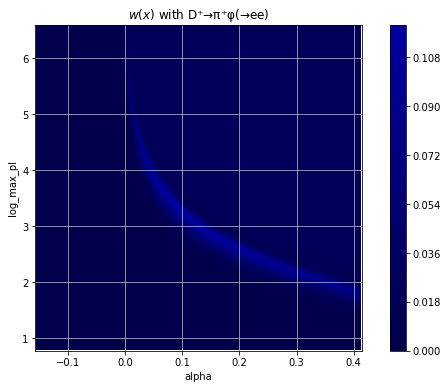

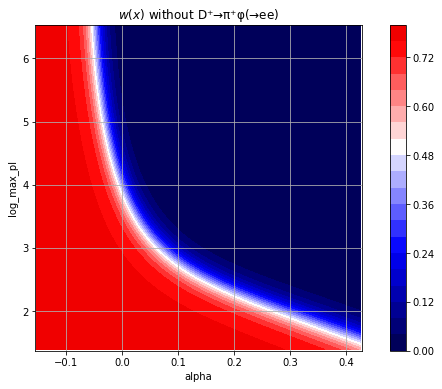

In [65]:
plot_field(w_la.w_model_np(), w_la.dataset(), r'$w(x)$ with %s'%df_index[3], save='result_la.pdf')
plot_field(w_la3.w_model_np(), w_la3.dataset(), r'$w(x)$ without %s'%df_index[3], save='result_la3.pdf')

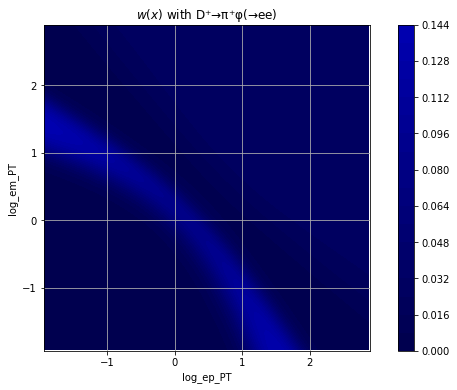

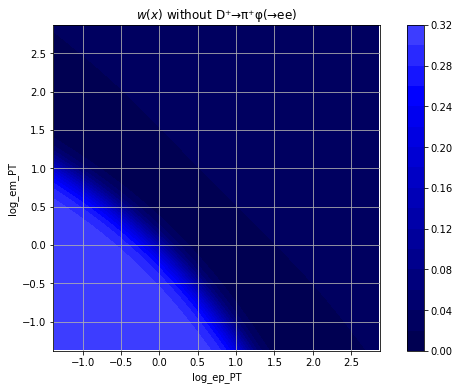

In [66]:
plot_field(w_ptpt.w_model_np(), w_ptpt.dataset(), r'$w(x)$ with %s'%df_index[3])
plot_field(w_ptpt3.w_model_np(), w_ptpt3.dataset(), r'$w(x)$ without %s'%df_index[3])

In [67]:
df = df.iloc[0:8,0:3]
df

Total       N   N/Total
B⁺→K⁺ee          970116  247104  0.254716
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759
D⁺→π⁺φ(→ee)      830027  830027  1.000000

In [68]:
for name, w in [("w₄[α,p]", w_la), ("w₃[α,p]", w_la3), ("w₄[pt,pt]", w_ptpt), ("w₃[pt,pt]", w_ptpt3)]:
    ds = w.dataset()
    name1 = "1-%s" % name
    r_name = "R[%s]" % name
    df[name1] = None
    for label, idx in ds.mapping.items():
        d = ds.X[ds.Y==label]
        wd = w.w_model_np()(d)
        df.loc[df.index[idx],name1] = 1-np.mean(wd)
    df[r_name] = None
    for label, idx in ds.mapping.items():
        df.loc[df.index[idx],r_name] = df.loc[df.index[1],name1] / df.loc[df.index[idx],name1]
df

Total       N   N/Total 1-w₄[α,p] R[w₄[α,p]] 1-w₃[α,p]  \
B⁺→K⁺ee          970116  247104  0.254716  0.960276   1.020538  0.916743   
B⁺→K⁺J/ψ(→ee)    960234  929755  0.968259  0.979998        1.0  0.979999   
B⁺→K⁺ψ(2S)(→ee)  986271  939679  0.952759      0.98   0.999998      0.98   
D⁺→π⁺φ(→ee)      830027  830027  1.000000  0.980008   0.999989      None   

                R[w₃[α,p]] 1-w₄[pt,pt] R[w₄[pt,pt]] 1-w₃[pt,pt] R[w₃[pt,pt]]  
B⁺→K⁺ee           1.069001    0.969633      1.01069    0.943368     1.038821  
B⁺→K⁺J/ψ(→ee)          1.0    0.979999          1.0    0.979991          1.0  
B⁺→K⁺ψ(2S)(→ee)   0.999999    0.979999          1.0    0.979997     0.999993  
D⁺→π⁺φ(→ee)           None        0.98     0.999999        None         None

### Conditional plots

In [69]:
def plot_e(w_obj, feature, bins, comment=None):
    ds = w_obj.dataset()
    ds_features = ds.features
    ds_comment = ds_features if comment is None else "%s, %s" % (ds_features, comment)
    Xf, Yf, mf = make_dataset(ds_features, range(4))
    Xc, Yc, mc = make_dataset([feature], range(4))
    fn = w_obj.w_model_np()
    bins_q2 = np.linspace(0,14e6,101)
    for label, idx in ds.mapping.items():
        d = Xf[Yf==label]
        wd = 1-fn(d)
        q2d = Xc[Yc==label]
        #print(wd.shape, q2d.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        plt.step(bins[:-1], hd, where='post', label=df_index[idx])
    plt.title("e(%s) for %s" % (feature, ds_comment))
    plt.legend()
    plt.grid()
    plt.show()

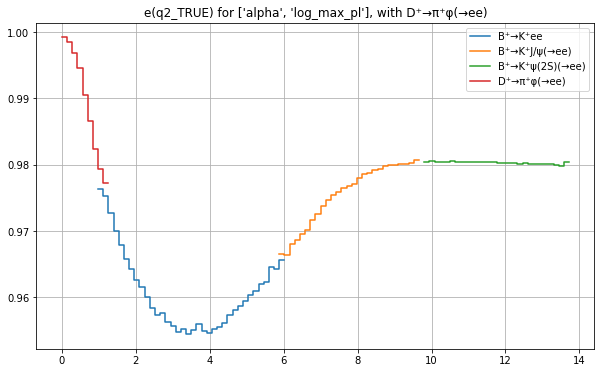

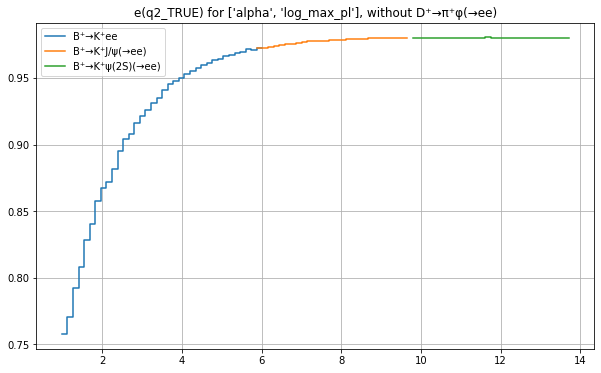

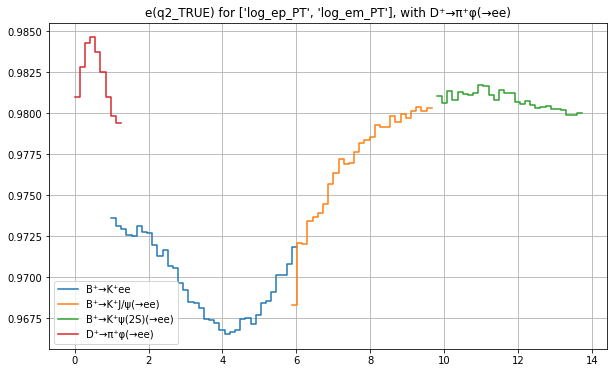

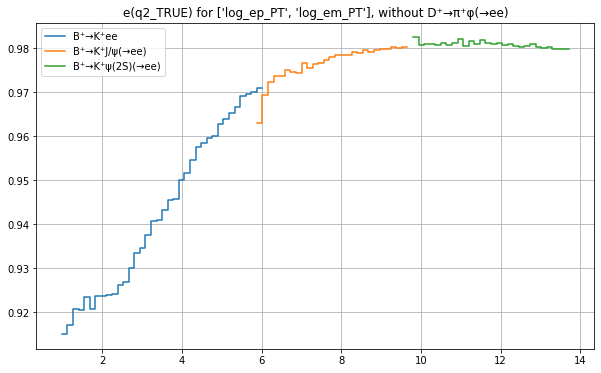

In [70]:
plot_e(w_la, "q2_TRUE", bins=np.linspace(0,14,101), comment="with %s" % df_index[3])
plot_e(w_la3, "q2_TRUE", bins=np.linspace(0,14,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "q2_TRUE", bins=np.linspace(0,14,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "q2_TRUE", bins=np.linspace(0,14,101), comment="without %s" % df_index[3])

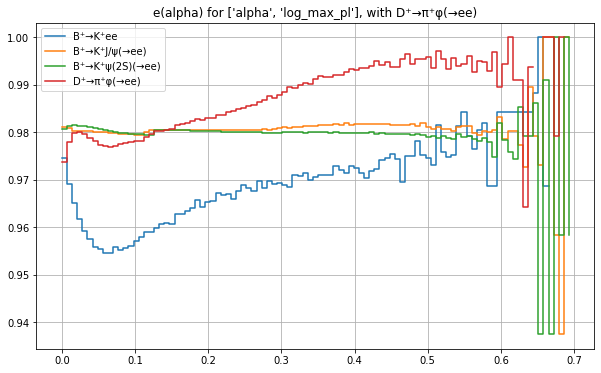

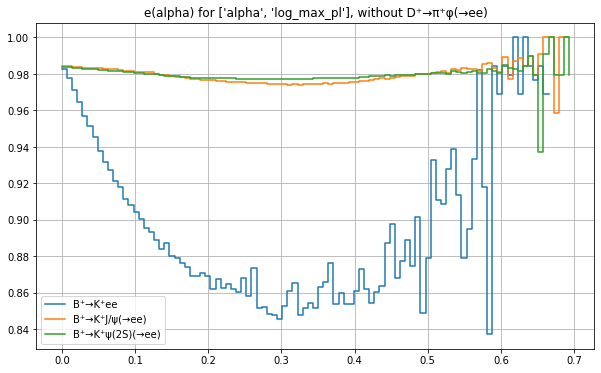

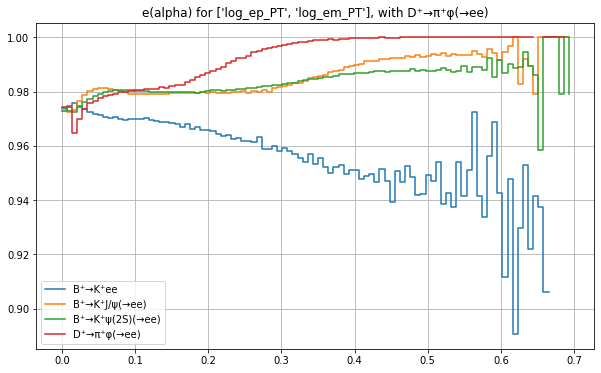

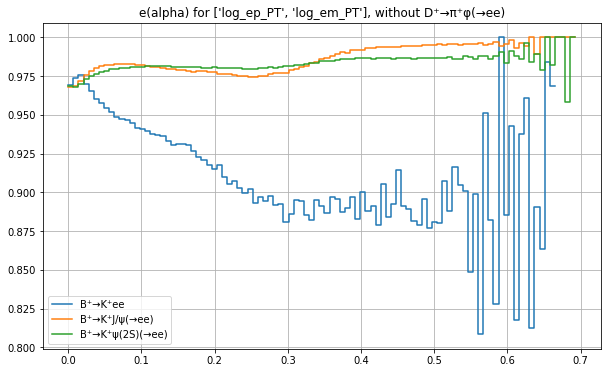

In [71]:
plot_e(w_la, "alpha", bins=np.linspace(0,0.7,101), comment="with %s" % df_index[3])
plot_e(w_la3, "alpha", bins=np.linspace(0,0.7,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "alpha", bins=np.linspace(0,0.7,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "alpha", bins=np.linspace(0,0.7,101), comment="without %s" % df_index[3])

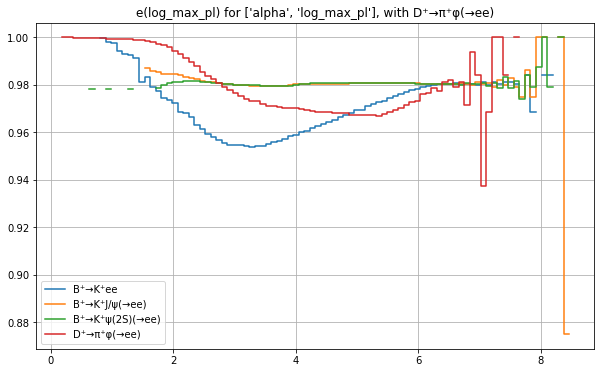

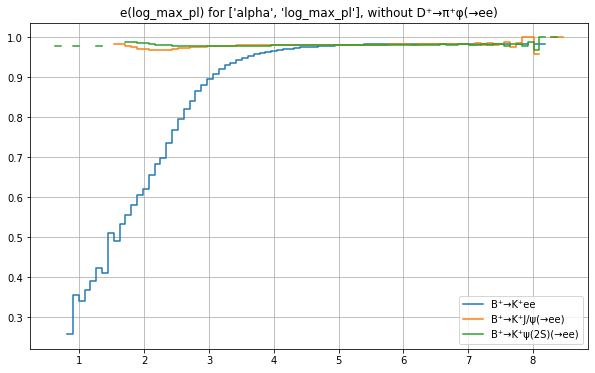

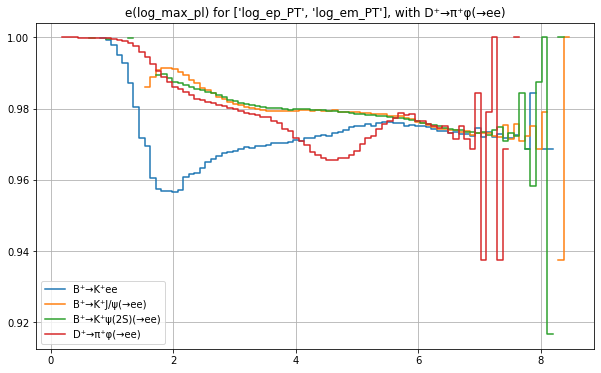

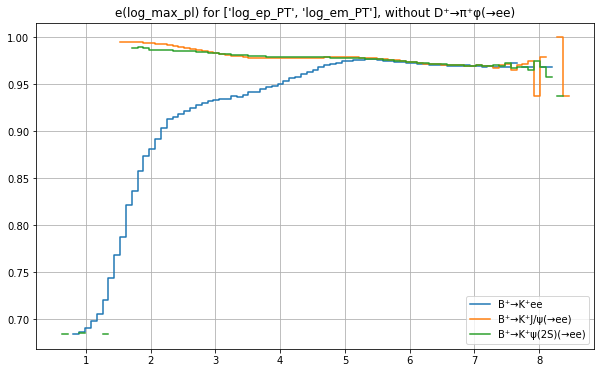

In [72]:
plot_e(w_la, "log_max_pl", bins=np.linspace(0,9,101), comment="with %s" % df_index[3])
plot_e(w_la3, "log_max_pl", bins=np.linspace(0,9,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "log_max_pl", bins=np.linspace(0,9,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "log_max_pl", bins=np.linspace(0,9,101), comment="without %s" % df_index[3])

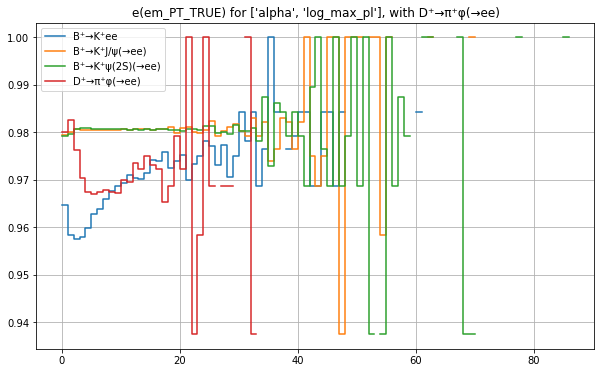

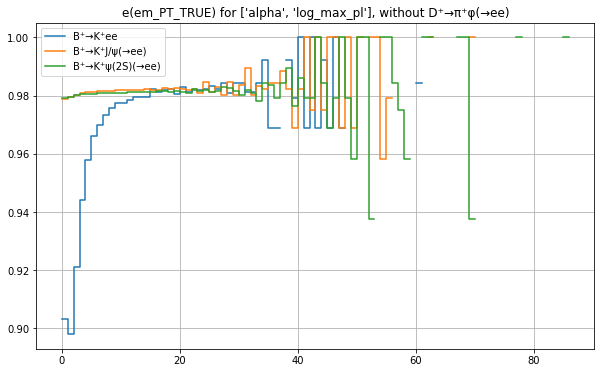

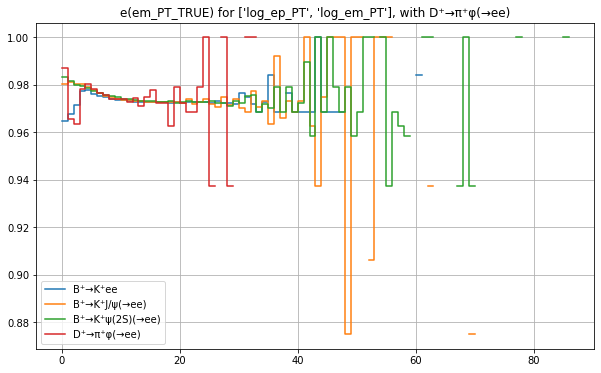

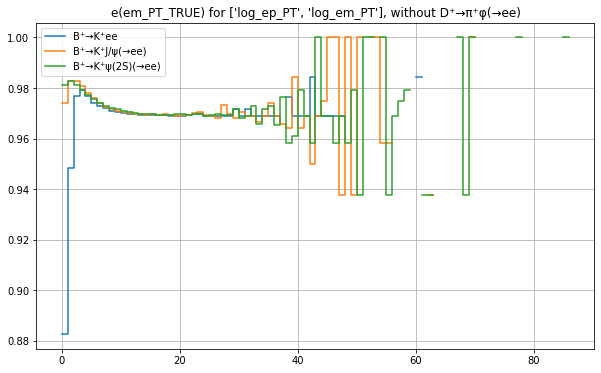

In [73]:
plot_e(w_la, "em_PT_TRUE", bins=np.linspace(0,100,101), comment="with %s" % df_index[3])
plot_e(w_la3, "em_PT_TRUE", bins=np.linspace(0,100,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "em_PT_TRUE", bins=np.linspace(0,100,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "em_PT_TRUE", bins=np.linspace(0,100,101), comment="without %s" % df_index[3])

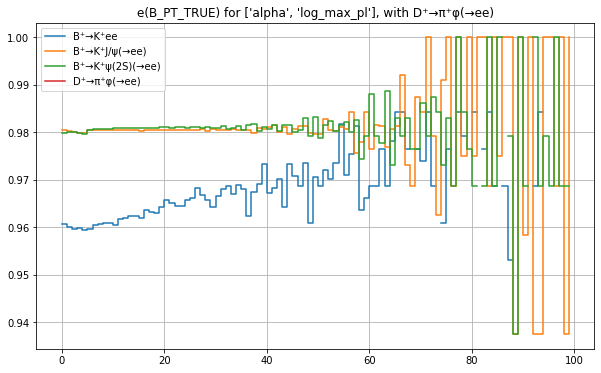

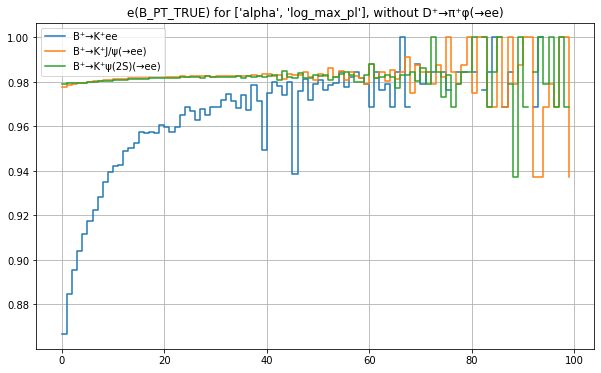

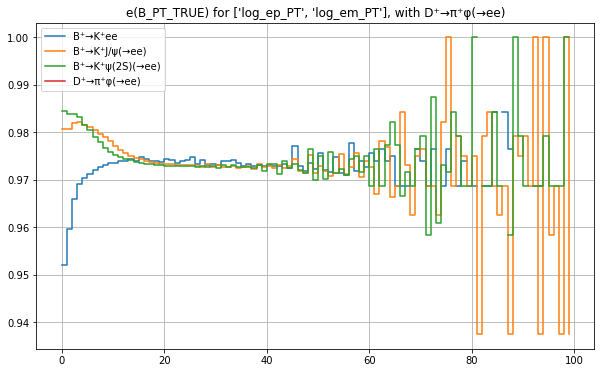

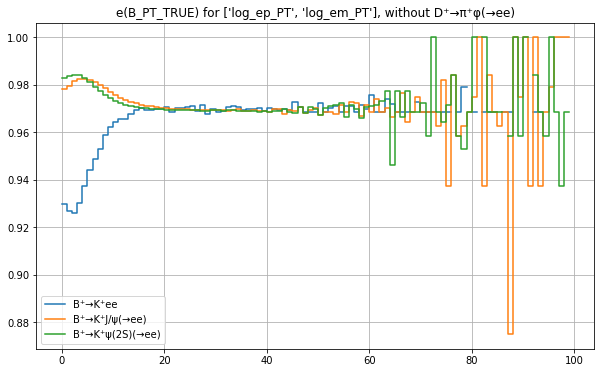

In [74]:
plot_e(w_la, "B_PT_TRUE", bins=np.linspace(0,100,101), comment="with %s" % df_index[3])
plot_e(w_la3, "B_PT_TRUE", bins=np.linspace(0,100,101), comment="without %s" % df_index[3])
plot_e(w_ptpt, "B_PT_TRUE", bins=np.linspace(0,100,101), comment="with %s" % df_index[3])
plot_e(w_ptpt3, "B_PT_TRUE", bins=np.linspace(0,100,101), comment="without %s" % df_index[3])

### Single feature

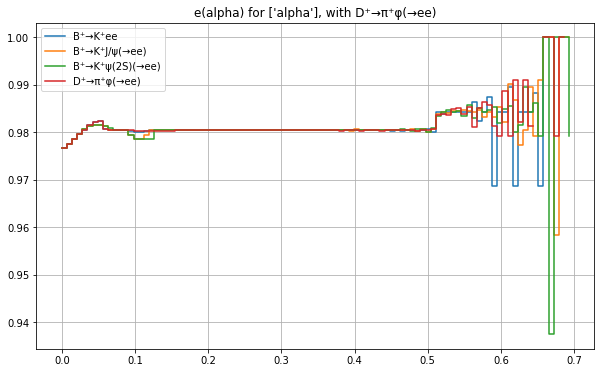

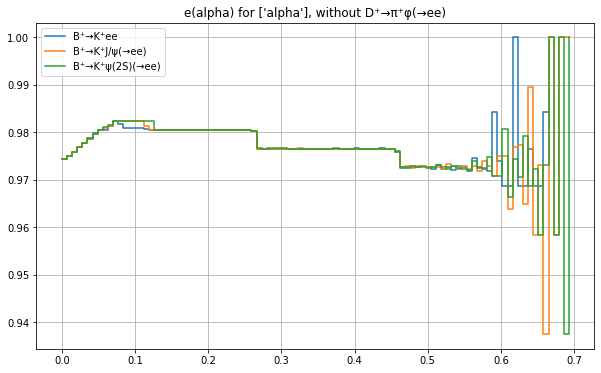

In [75]:
plot_e(w_a4, "alpha", bins=np.linspace(0,0.7,101), comment="with %s" % df_index[3])
plot_e(w_a3, "alpha", bins=np.linspace(0,0.7,101), comment="without %s" % df_index[3])

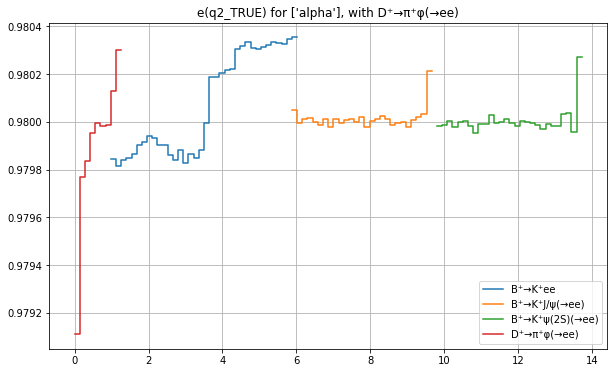

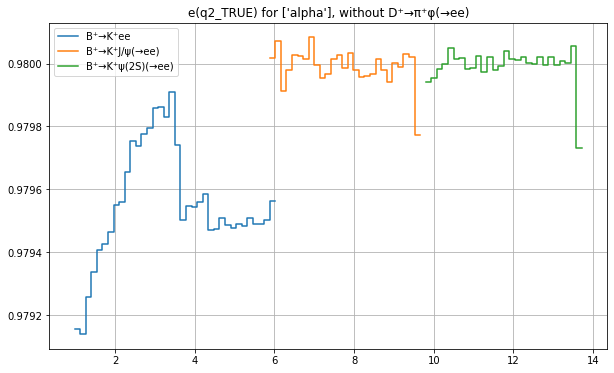

In [76]:
plot_e(w_a4, "q2_TRUE", bins=np.linspace(0,14,101), comment="with %s" % df_index[3])
plot_e(w_a3, "q2_TRUE", bins=np.linspace(0,14,101), comment="without %s" % df_index[3])